## EDA for NOMAD 2018 Transparent Conductors Dataset

In [83]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [84]:
# paths
zip_path = "../data/nomad2018-predict-transparent-conductors.zip"
extract_path = "../data/nomad2018"

# create target directory... if needed
os.makedirs(extract_path, exist_ok=True)

# unzip all contents
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped to:", extract_path)
print("Contents:", os.listdir(extract_path))

Unzipped to: ../data/nomad2018
Contents: ['test.zip', 'test.csv.zip', 'train.csv.zip', 'test.csv', 'sample_submission.csv.zip', 'train.zip', 'train.csv']


In [85]:

nested_zip_path = os.path.join(extract_path, "train.csv.zip")
with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(extract_path))

nested_zip_path = os.path.join(extract_path, "test.csv.zip")
with zipfile.ZipFile(nested_zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.join(extract_path))

In [86]:
!ls $extract_path

sample_submission.csv.zip  test.csv.zip  train.csv	train.zip
test.csv		   test.zip	 train.csv.zip


### LOAD TRAINING AND TEST SET
#### No need for sample_submission here. Only working with training data set for EDA

In [124]:
# load train.csv // TRAIN
train_path = os.path.join(extract_path, "train.csv")
train_df = pd.read_csv(train_path)

# load test.csv // TEST
test_path = os.path.join(extract_path, "test.csv")
test_df = pd.read_csv(test_path)

# inspect train // TRAIN
print("Shape:", train_df.shape)
print("Columns:", train_df.columns.tolist())
train_df.head()

# inspect // TEST
print("Shape:", test_df.shape)
print("Columns:", test_df.columns.tolist())
test_df.head()

Shape: (2400, 14)
Columns: ['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al', 'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang', 'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree', 'formation_energy_ev_natom', 'bandgap_energy_ev']
Shape: (600, 12)
Columns: ['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al', 'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang', 'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']


id  spacegroup  number_of_total_atoms  percent_atom_al  percent_atom_ga  \
0   1          33                   80.0           0.1875           0.4688   
1   2          33                   80.0           0.7500           0.2500   
2   3         167                   30.0           0.6667           0.1667   
3   4          12                   80.0           0.5625           0.4375   
4   5          12                   80.0           0.1875           0.5000   

   percent_atom_in  lattice_vector_1_ang  lattice_vector_2_ang  \
0           0.3438               10.5381                9.0141   
1           0.0000                9.8938                8.5014   
2           0.1667                4.9811                4.9808   
3           0.0000               24.3370                6.0091   
4           0.3125               24.6443                6.2906   

   lattice_vector_3_ang  lattice_angle_alpha_degree  \
0                9.6361                     89.9997   
1                9.1298                     90.0038   
2               13.4799                     89.9900   
3                5.7620                     89.9995   
4                6.1589                     90.0000   

   lattice_angle_beta_degree  lattice_angle_gamma_degree  
0                    90.0003                     90.0006  
1                    90.0023                     90.0015  
2                    90.0109                    120.0014  
3                   103.8581                     90.0002  
4                   104.5929                     90.0001

We can see that test data set does not include 'formation_energy_ev_natom' and 'bandgap_energy_ev'. ** These are the variables we will be predicting for. 

In [128]:
train_num = train_df.select_dtypes(include="number").columns
test_num  = test_df.select_dtypes(include="number").columns

# As a health check I want to only keep columns present in BOTH train and test - to view side by side
common_numeric = [c for c in train_num if c in test_num]

# explicitely dropping columns
drop_cols = ["formation_energy_ev_natom", "band_gap_energy_ev"]
common_numeric = [c for c in common_numeric if c not in drop_cols]


In [126]:
print("---- Data Info ----")
train_df.info()

---- Data Info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          2400 non-null   int64  
 1   spacegroup                  2400 non-null   int64  
 2   number_of_total_atoms       2400 non-null   float64
 3   percent_atom_al             2400 non-null   float64
 4   percent_atom_ga             2400 non-null   float64
 5   percent_atom_in             2400 non-null   float64
 6   lattice_vector_1_ang        2400 non-null   float64
 7   lattice_vector_2_ang        2400 non-null   float64
 8   lattice_vector_3_ang        2400 non-null   float64
 9   lattice_angle_alpha_degree  2400 non-null   float64
 10  lattice_angle_beta_degree   2400 non-null   float64
 11  lattice_angle_gamma_degree  2400 non-null   float64
 12  formation_energy_ev_natom   2400 non-null   float64
 13  bandgap_energ

### Distribution of Formation Energy and Band Gap per instance or molecule

In [95]:

#### What is the relation between formation energy and molecule stability?
#### The change in energy when one mole of a substance is formed from its constituent elements in their standard states
#### most common "instability" level is around 0.1-0.2 eV/atom ; 0 is stable
#### Band Gap - How transparent is the molecule? Semiconductor Properties?
### ----

# Band gap is the energy (in electron-Volts) required to excite an electron, making it conductive.
# Low Band Gap (< 1.5 eV): These are opaque semiconductors (like silicon) or metals, they absorb visible light.
# High Band Gap (> 3.1 eV): These are transparent to visible light because the light's energy isn't high enough to excite the electrons.
# Very High Band Gap (> 4.0 eV): These are typically insulators, which are very hard to make conductive.

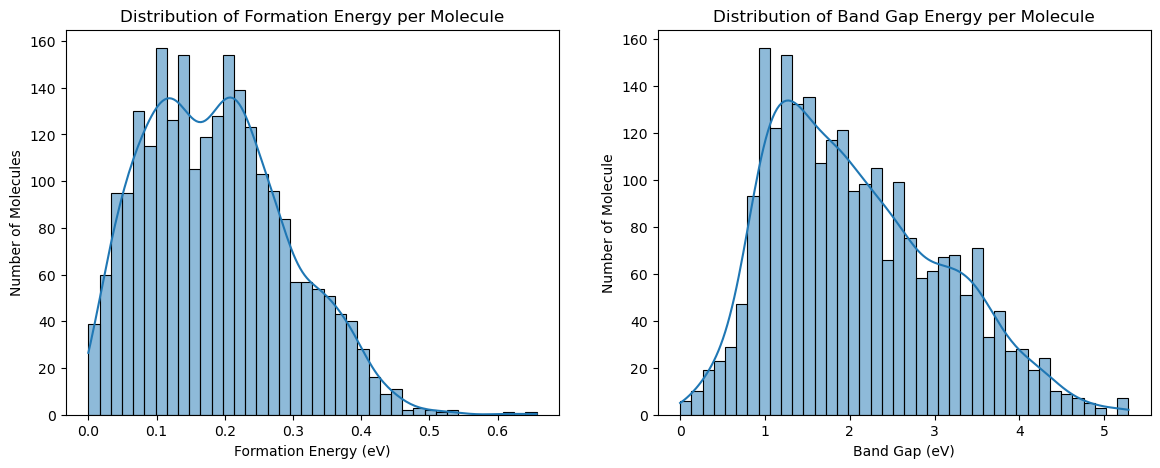

In [96]:
train_df.columns

fig, ax = plt.subplots(1, 2, figsize=(14,5))

sns.histplot(train_df['formation_energy_ev_natom'], bins=40, kde=True, ax=ax[0])
ax[0].set_title("Distribution of Formation Energy per Molecule")
ax[0].set_xlabel('Formation Energy (eV)')
ax[0].set_ylabel('Number of Molecules')

sns.histplot(train_df['bandgap_energy_ev'], bins=40, kde=True, ax=ax[1])
ax[1].set_title("Distribution of Band Gap Energy per Molecule")
ax[1].set_xlabel('Band Gap (eV)')
ax[1].set_ylabel('Number of Molecule')

plt.show()


#### Summary Statistics

In [92]:
train_df.describe()


id   spacegroup  number_of_total_atoms  percent_atom_al  \
count  2400.000000  2400.000000            2400.000000      2400.000000   
mean   1200.500000   141.517917              61.679167         0.385439   
std     692.964646    84.715548              22.598337         0.265566   
min       1.000000    12.000000              10.000000         0.000000   
25%     600.750000    33.000000              40.000000         0.166700   
50%    1200.500000   194.000000              80.000000         0.375000   
75%    1800.250000   206.000000              80.000000         0.583300   
max    2400.000000   227.000000              80.000000         1.000000   

       percent_atom_ga  percent_atom_in  lattice_vector_1_ang  \
count      2400.000000      2400.000000           2400.000000   
mean          0.308601         0.305958             10.030005   
std           0.233717         0.263198              5.645457   
min           0.000000         0.000000              3.037000   
25%           0.093800         0.062500              6.141100   
50%           0.281200         0.250000              9.537450   
75%           0.468800         0.468800             10.292100   
max           1.000000         1.000000             24.913400   

       lattice_vector_2_ang  lattice_vector_3_ang  lattice_angle_alpha_degree  \
count           2400.000000           2400.000000                 2400.000000   
mean               7.086977             12.593288                   90.243666   
std                1.890330              5.450746                    1.333655   
min                2.942300              5.672500                   82.744100   
25%                5.833625              9.298000                   89.999700   
50%                6.382950             10.125000                   90.001700   
75%                9.093450             14.372050                   90.006200   
max               10.290300             25.346000                  101.229800   

       lattice_angle_beta_degree  lattice_angle_gamma_degree  \
count                2400.000000                 2400.000000   
mean                   92.398971                   94.787600   
std                     5.299734                   25.868516   
min                    81.641300                   29.727400   
25%                    90.000900                   89.998700   
50%                    90.003550                   90.000400   
75%                    90.014400                  119.998325   
max                   106.168200                  120.053500   

       formation_energy_ev_natom  bandgap_energy_ev  
count                2400.000000        2400.000000  
mean                    0.187614           2.077205  
std                     0.104100           1.006845  
min                     0.000000           0.000100  
25%                     0.105600           1.278500  
50%                     0.181800           1.907850  
75%                     0.256275           2.761950  
max                     0.657200           5.286100

### Correlation Matrix of All Features for Training which include formation energy and band gap

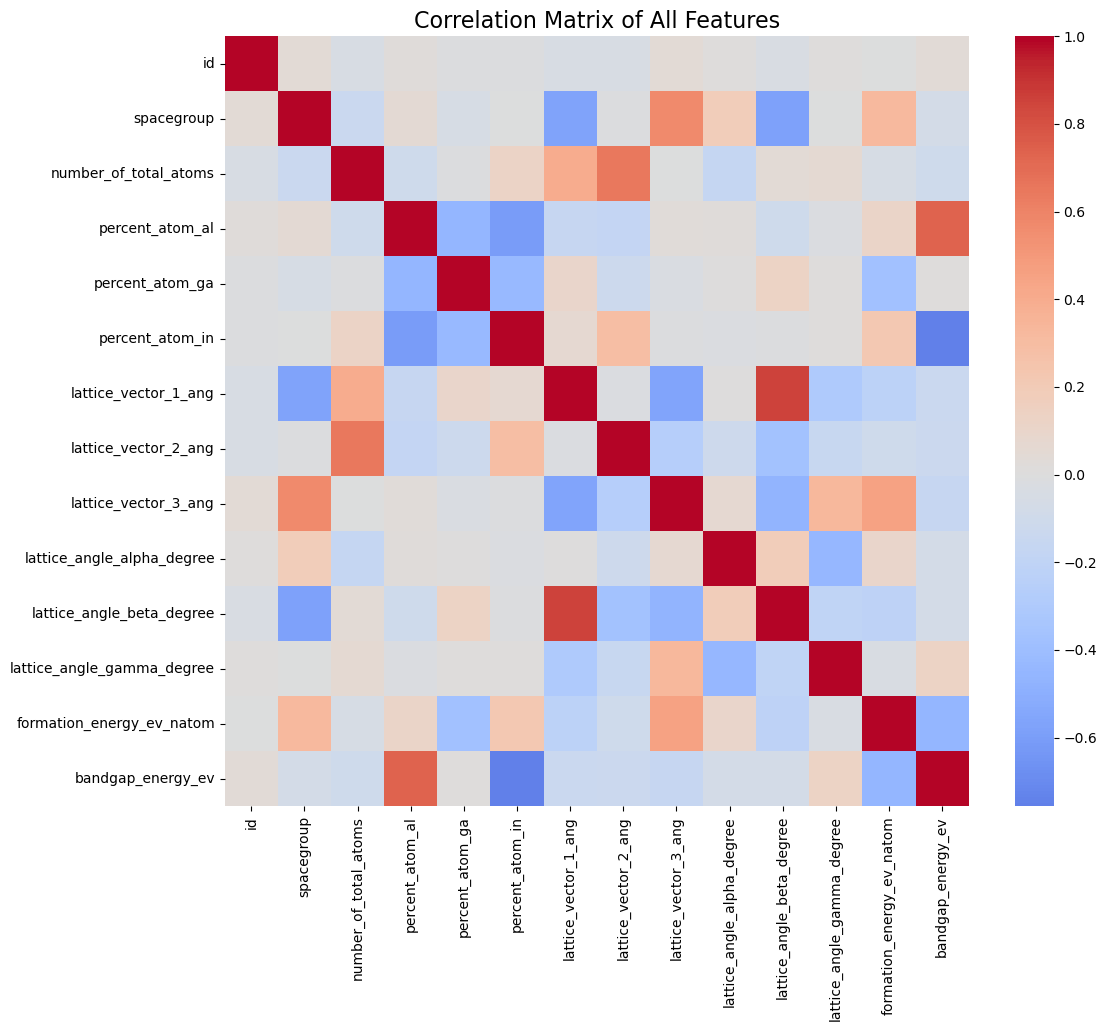

In [97]:
plt.figure(figsize=(12,10))
corr = train_df.corr(numeric_only=True)

sns.heatmap(corr, cmap='coolwarm', annot=False, center=0)
plt.title("Correlation Matrix of All Features", fontsize=16)
plt.show()

### Different View of Correlation (List View)

In [116]:
target = "bandgap_energy_ev"
train_df.corr(numeric_only=True)[target].sort_values(ascending=False)


bandgap_energy_ev             1.000000
percent_atom_al               0.738622
lattice_angle_gamma_degree    0.133285
id                            0.034987
percent_atom_ga               0.012831
lattice_angle_alpha_degree   -0.072313
spacegroup                   -0.072725
lattice_angle_beta_degree    -0.077048
number_of_total_atoms        -0.106125
lattice_vector_2_ang         -0.127461
lattice_vector_1_ang         -0.138901
lattice_vector_3_ang         -0.156865
formation_energy_ev_natom    -0.454246
percent_atom_in              -0.756668
Name: bandgap_energy_ev, dtype: float64

In [117]:
from scipy.stats import zscore

numeric_cols = train_df.select_dtypes(include='number').columns
z = np.abs(zscore(train_df[numeric_cols]))

outliers = (z > 3).sum()
pd.DataFrame(outliers, index=numeric_cols, columns=["n_outliers"])


n_outliers
id                                  91
spacegroup                          91
number_of_total_atoms               91
percent_atom_al                     91
percent_atom_ga                     91
percent_atom_in                     91
lattice_vector_1_ang                91
lattice_vector_2_ang                91
lattice_vector_3_ang                91
lattice_angle_alpha_degree          91
lattice_angle_beta_degree           91
lattice_angle_gamma_degree          91
formation_energy_ev_natom           91
bandgap_energy_ev                   91

#### For my own personal check, comparing train and test // unnecessary I know

In [113]:
train_num = train_df.select_dtypes(include="number").columns
test_num  = test_df.select_dtypes(include="number").columns

# only keep columns present in BOTH train and test
common_numeric = [c for c in train_num if c in test_num]

# drop columns
drop_cols = ["formation_energy_ev_natom", "band_gap_energy_ev"]
common_numeric = [c for c in common_numeric if c not in drop_cols]

print("Columns being plotted:", common_numeric)


Columns being plotted: ['id', 'spacegroup', 'number_of_total_atoms', 'percent_atom_al', 'percent_atom_ga', 'percent_atom_in', 'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang', 'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']


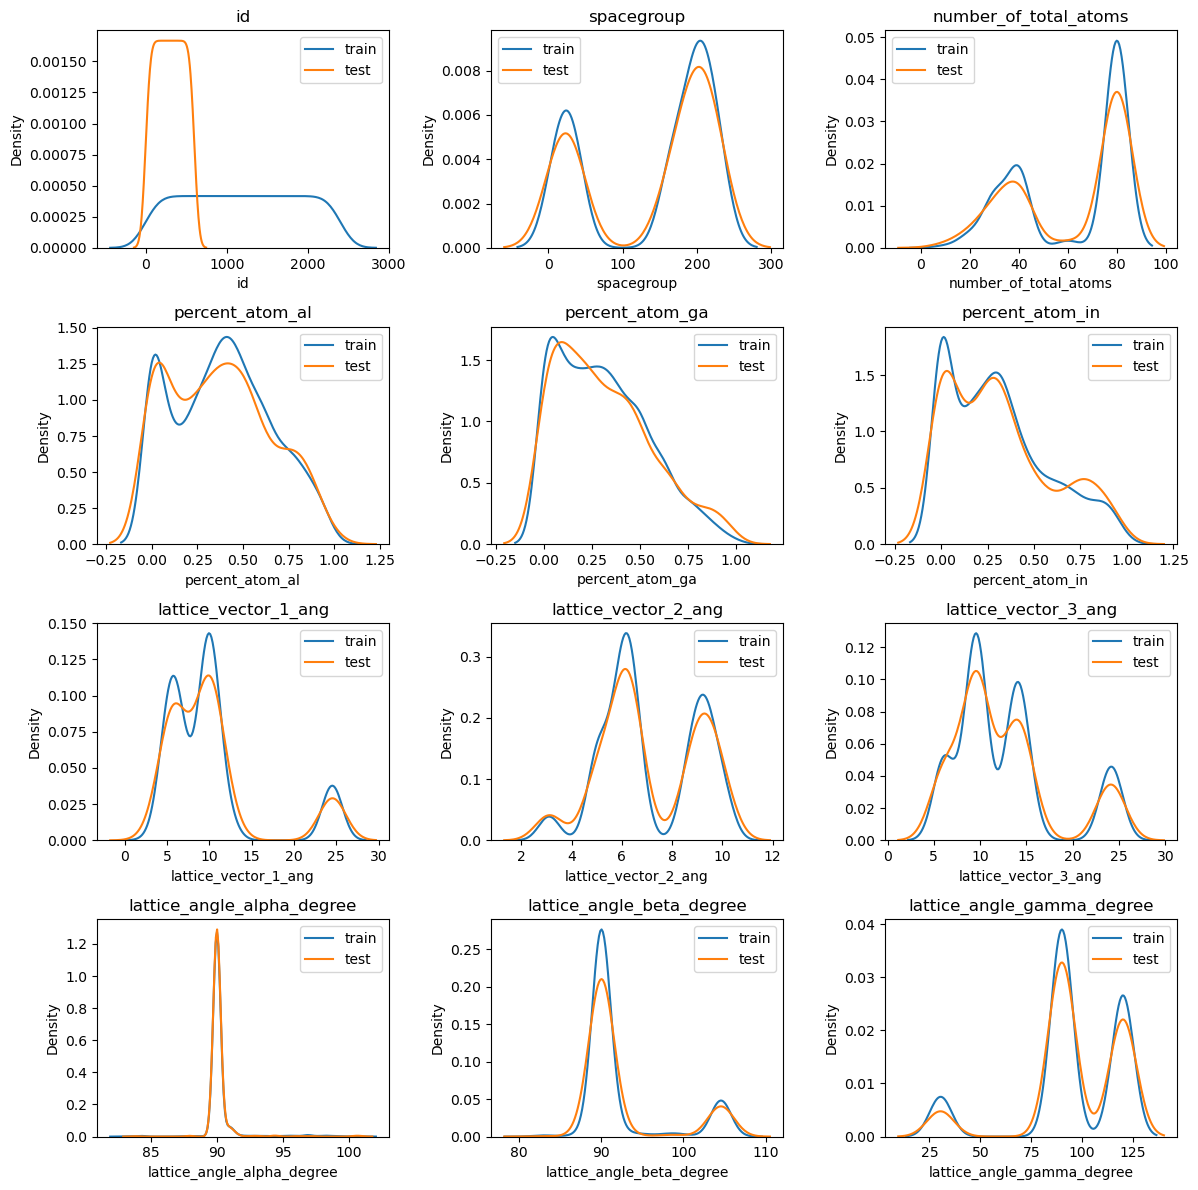

In [129]:
import math

cols_per_row = 3
n_plots = len(common_numeric)
n_rows = math.ceil(n_plots / cols_per_row)

fig, axes = plt.subplots(
    n_rows, cols_per_row,
    figsize=(cols_per_row * 4, n_rows * 3),
    squeeze=False
)

axes = axes.flatten()

for ax, col in zip(axes, common_numeric):
    sns.kdeplot(train_df[col].dropna(), label="train", ax=ax)
    sns.kdeplot(test_df[col].dropna(),  label="test",  ax=ax)
    ax.set_title(col)
    ax.legend()

# Hide any unused axes (e.g. if #cols not multiple of 3)
for j in range(len(common_numeric), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Same but only looking at training data specifically

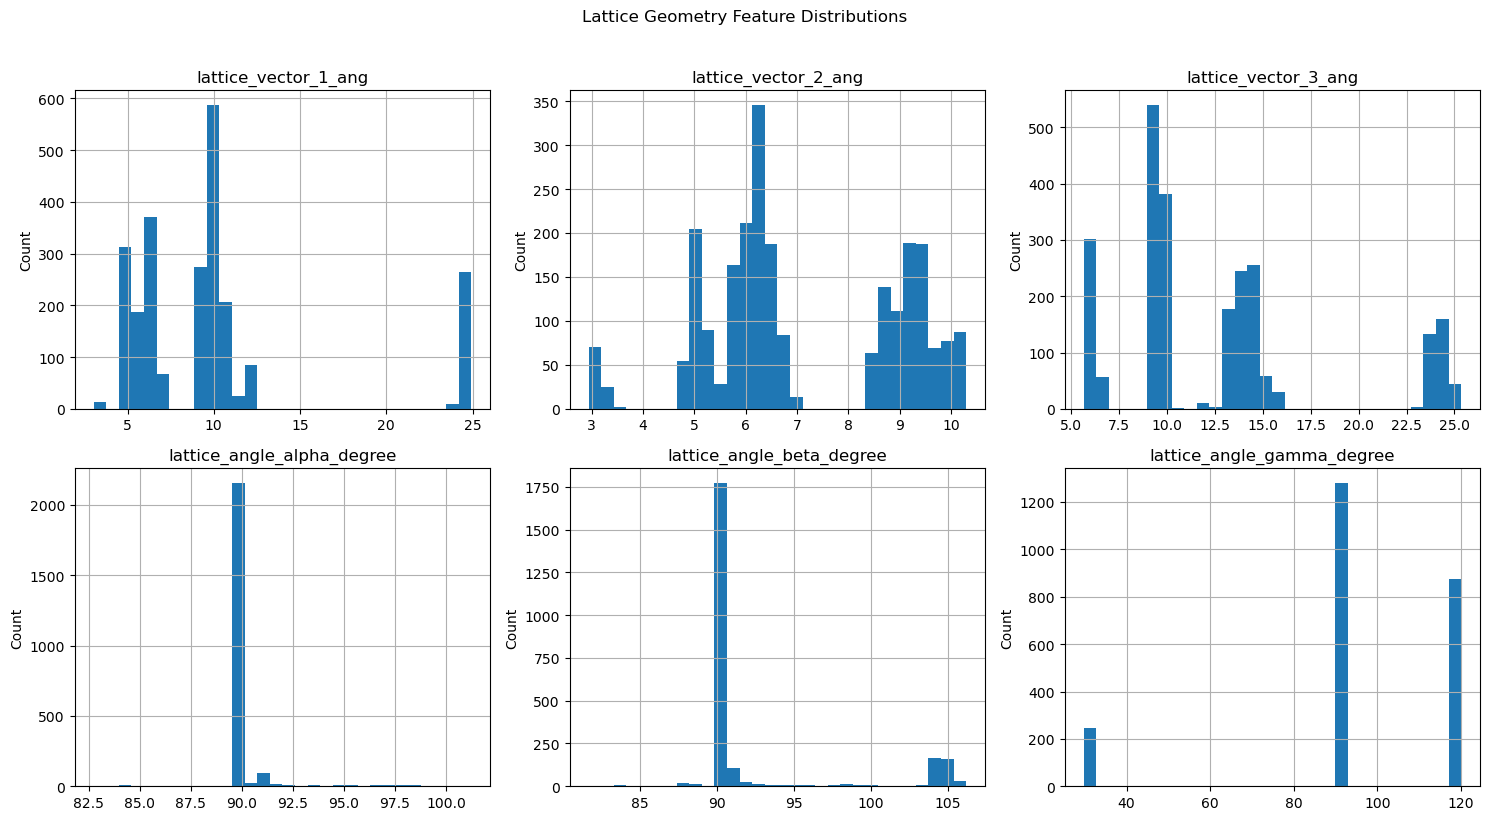

In [130]:
import matplotlib.pyplot as plt

geo_cols = [
    'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang',
    'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree'
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(geo_cols):
    ax = axes[i]
    train_df[col].hist(ax=ax, bins=30)
    ax.set_title(col)
    ax.set_xlabel("")  # optional
    ax.set_ylabel("Count")

# If there are any extra axes (there aren’t here, but just in case)
for j in range(len(geo_cols), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Lattice Geometry Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

#### Formation Energy v. Band Gap

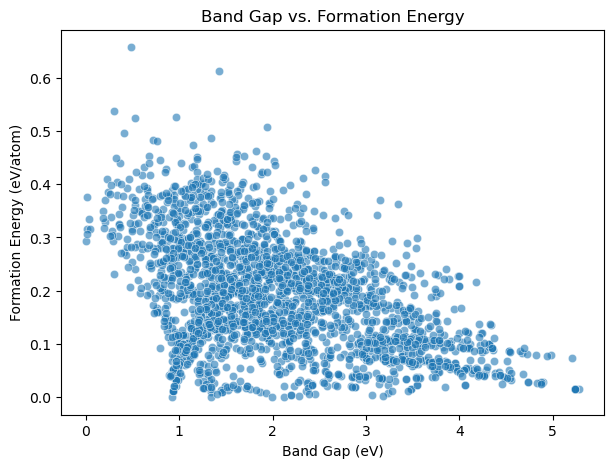

In [149]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=train_df,
    x='bandgap_energy_ev',
    y='formation_energy_ev_natom',
    alpha=0.6
)
plt.xlabel("Band Gap (eV)")
plt.ylabel("Formation Energy (eV/atom)")
plt.title("Band Gap vs. Formation Energy")
plt.show()


## Fix this with bullets and such
What this plot represents:
1) x-axis → formation_energy_ev_natom
1a) Thermodynamic measure of how stable the material is.
1b) Lower (especially negative) = more stable.
1c) Higher positive values = unstable, energentically unfavorable.

2) y-axis → bandgap_energy_ev
2a) Electronic property.
2b) 0 = metals
2c) 1–3 = semiconductors
2ci) 3 = insulators

There is no strong correlation between both properties.
Formation energy is correlated to thermodynamic stability also band gap is correlated to electronic structure - this was gathered from research

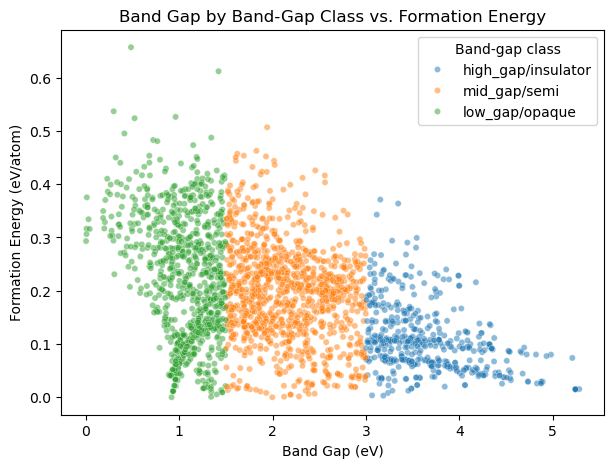

In [294]:
def bandgap_class(x):
    if x < 1.5:
        return 'low_gap/opaque'
    elif x < 3.0:
        return 'mid_gap/semi'
    else:
        return 'high_gap/insulator'

train_df['gap_class'] = train_df['bandgap_energy_ev'].apply(bandgap_class)

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=train_df,
    x='bandgap_energy_ev',
    y='formation_energy_ev_natom',
    hue='gap_class',
    alpha=0.5,
    s=20
)
plt.xlabel("Band Gap (eV)")
plt.ylabel("Formation Energy (eV/atom)")
plt.title("Band Gap by Band-Gap Class vs. Formation Energy")
plt.legend(title="Band-gap class")
plt.show()


No true relationship between formation energy and band gap. I made 3 classes based on literature to relate to band gap to check if more insight is acquired. Band gap classes reveal that all three classes fall formation energies throughout but can be seen as concentrated towards higher formation energy.
conductors in low gap class: x < 1.5eV
semi conductors in mid gap class: 1.5 < x < 3.0eV
insulators in high gap class: x > 3eV

More questions to answer: How does thermodynamic stability vary as a function of band gap energy?

Some PCA for numerical structure + compositional features:

In [295]:
feature_cols = [
    'number_of_total_atoms',
    'percent_atom_al', 'percent_atom_ga', 'percent_atom_in',
    'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang',
    'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree'
]

In [296]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = train_df[feature_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [297]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

train_df['PC1'] = X_pca[:, 0]
train_df['PC2'] = X_pca[:, 1]


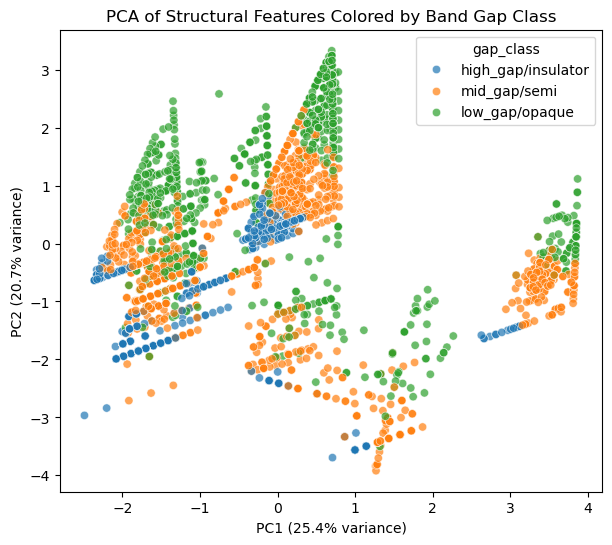

In [298]:
plt.figure(figsize=(7,6))
sns.scatterplot(
    data=train_df,
    x='PC1', y='PC2',
    hue='gap_class',
    alpha=0.7
)
plt.title("PCA of Structural Features Colored by Band Gap Class")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)")
plt.show()


In [299]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)
loadings

PC1       PC2
number_of_total_atoms       0.195372  0.452153
percent_atom_al            -0.186381 -0.307448
percent_atom_ga             0.105259 -0.160605
percent_atom_in             0.094592  0.452829
lattice_vector_1_ang        0.582185 -0.032893
lattice_vector_2_ang        0.080912  0.570176
lattice_vector_3_ang       -0.446669  0.006415
lattice_angle_alpha_degree  0.098446 -0.242776
lattice_angle_beta_degree   0.512409 -0.267822
lattice_angle_gamma_degree -0.299686  0.115299

UMAP (Uniform Manifold Approximation and Projection) -- Will use to reduce dimensions to lower space for further analysis - global structure

Structural features like lattice vectors, lattice angles, composition percentages, and total atoms will cluster into distinct families if you will. This shows that band gap is nonlinear function thats deeper than just geometry alone.

In [300]:
feature_cols = [
    "number_of_total_atoms",
    "percent_atom_al",
    "percent_atom_ga",
    "percent_atom_in",
    "lattice_vector_1_ang",
    "lattice_vector_2_ang",
    "lattice_vector_3_ang",
    "lattice_angle_alpha_degree",
    "lattice_angle_beta_degree",
    "lattice_angle_gamma_degree"
]

X = train_df[feature_cols].copy()

In [301]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/home/mica00/miniconda3/envs/chem277b/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


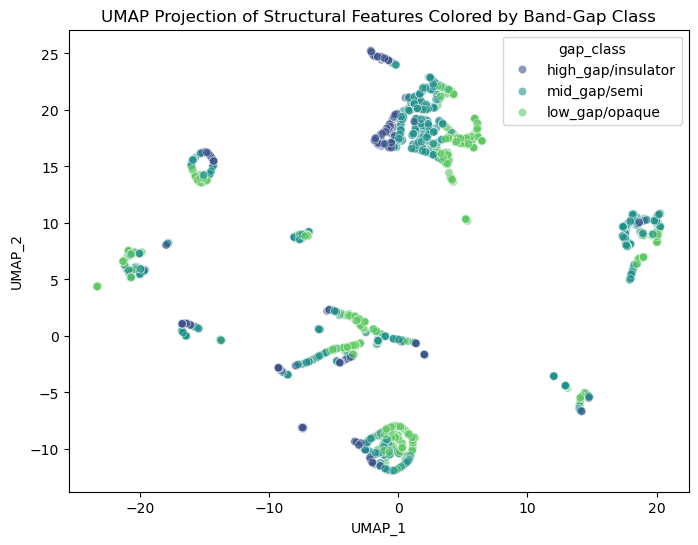

In [302]:
import umap.umap_ as umap
import seaborn as sns
import matplotlib.pyplot as plt

reducer = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    metric="euclidean",
    random_state=42
)

X_umap = reducer.fit_transform(X_scaled)

train_df["UMAP_1"] = X_umap[:, 0]
train_df["UMAP_2"] = X_umap[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x="UMAP_1", y="UMAP_2",
    hue="gap_class",
    alpha=0.6,
    palette="viridis"
)
plt.title("UMAP Projection of Structural Features Colored by Band-Gap Class")
plt.show()


t-SNE (t-distributed Stochastic Neighbor Embedding) -- Will use to reduce dimensions to lower space for further analysis -- local structure

In [303]:
from sklearn.manifold import TSNE
TSNE

sklearn.manifold._t_sne.TSNE

In [304]:
from sklearn.manifold import TSNE
help(TSNE)

Help on class TSNE in module sklearn.manifold._t_sne:

class TSNE(sklearn.base.ClassNamePrefixFeaturesOutMixin, sklearn.base.TransformerMixin, sklearn.base.BaseEstimator)
 |  TSNE(n_components=2, *, perplexity=30.0, early_exaggeration=12.0, learning_rate='auto', max_iter=1000, n_iter_without_progress=300, min_grad_norm=1e-07, metric='euclidean', metric_params=None, init='pca', verbose=0, random_state=None, method='barnes_hut', angle=0.5, n_jobs=None)
 |
 |  T-distributed Stochastic Neighbor Embedding.
 |
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |
 |  It is highly recommended to use another dimensionality reduction
 |  meth

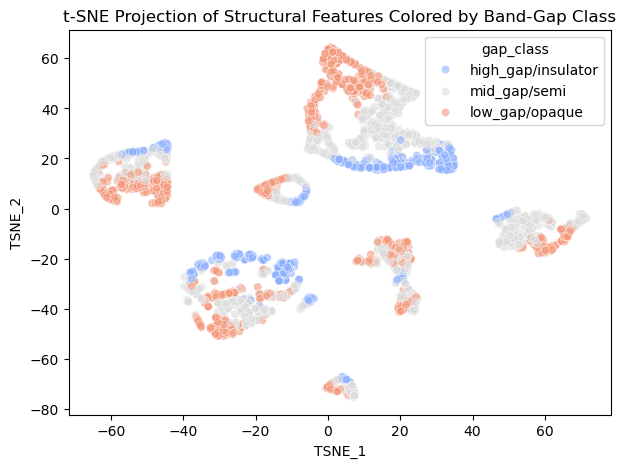

In [305]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    perplexity=40,
    learning_rate=200,
    random_state=42
)

X_tsne = tsne.fit_transform(X_scaled)

train_df["TSNE_1"] = X_tsne[:, 0]
train_df["TSNE_2"] = X_tsne[:, 1]


plt.figure(figsize=(7,5))
sns.scatterplot(
    data=train_df,
    x="TSNE_1",
    y="TSNE_2",
    hue="gap_class",
    alpha=0.6,
    palette="coolwarm"
)
plt.title("t-SNE Projection of Structural Features Colored by Band-Gap Class")
plt.show()

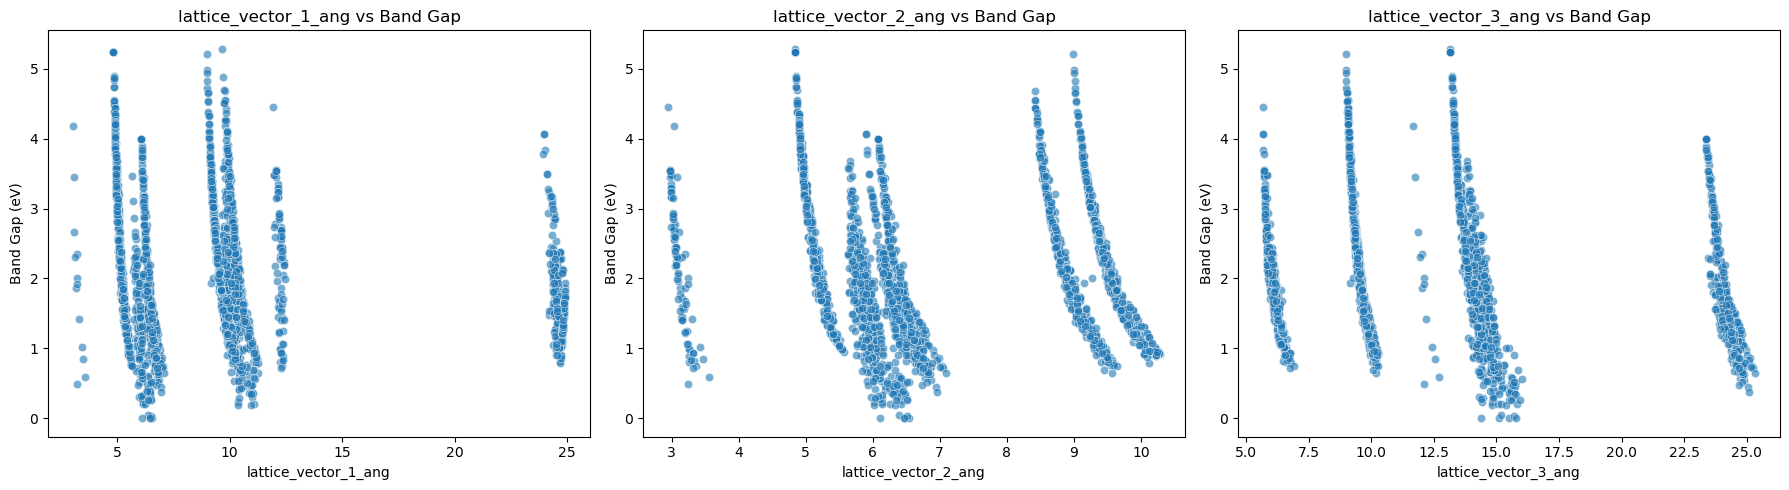

In [306]:
import matplotlib.pyplot as plt
import seaborn as sns

vec_cols = ['lattice_vector_1_ang', 
            'lattice_vector_2_ang', 
            'lattice_vector_3_ang']

plt.figure(figsize=(18,5))

for i, col in enumerate(vec_cols):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=train_df, x=col, y='bandgap_energy_ev', alpha=0.6)
    plt.title(f"{col} vs Band Gap")
    plt.xlabel(col)
    plt.ylabel("Band Gap (eV)")

plt.tight_layout()
plt.show()


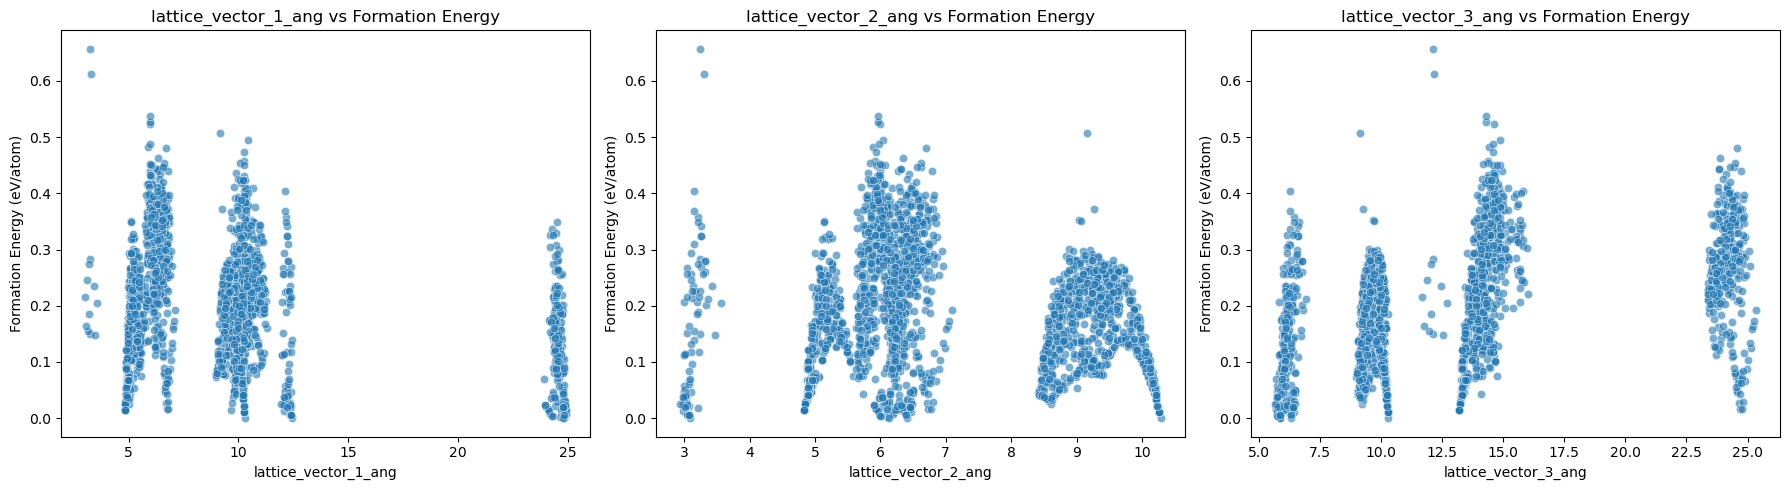

In [307]:
plt.figure(figsize=(18,5))

for i, col in enumerate(vec_cols):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=train_df, x=col, y='formation_energy_ev_natom', alpha=0.6)
    plt.title(f"{col} vs Formation Energy")
    plt.xlabel(col)
    plt.ylabel("Formation Energy (eV/atom)")

plt.tight_layout()
plt.show()


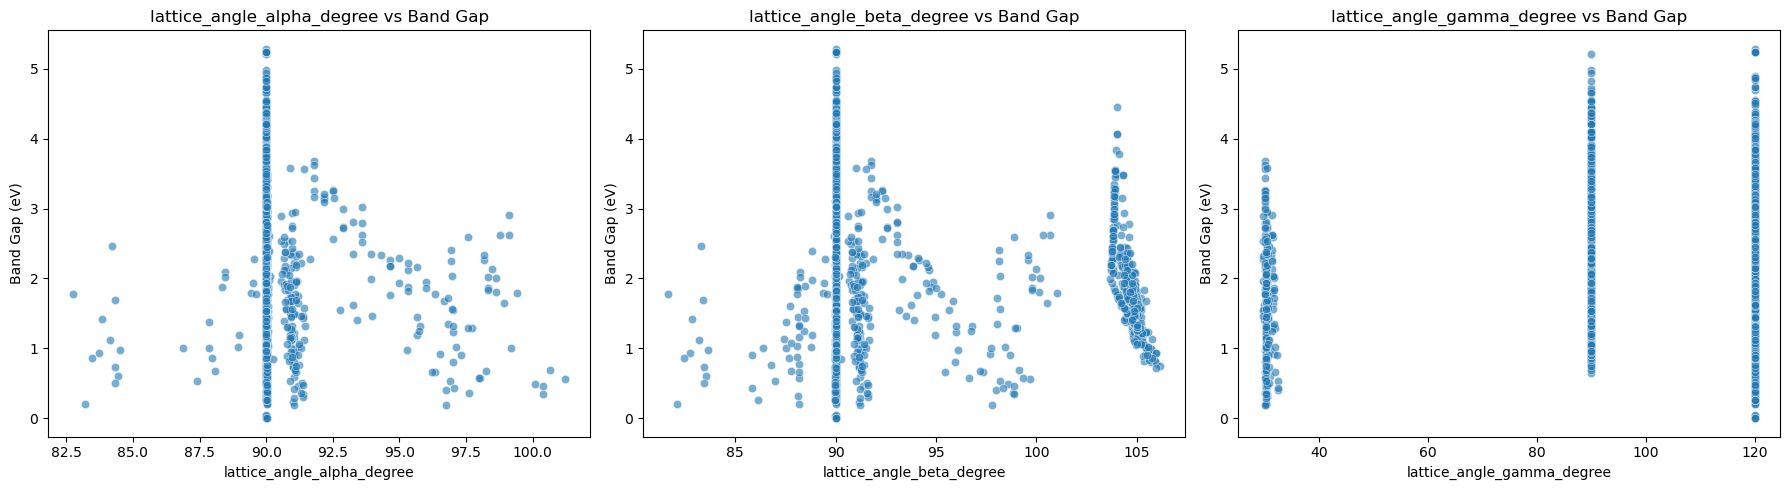

In [308]:
angle_cols = ['lattice_angle_alpha_degree',
              'lattice_angle_beta_degree',
              'lattice_angle_gamma_degree']

plt.figure(figsize=(18,5))

for i, col in enumerate(angle_cols):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=train_df, x=col, y='bandgap_energy_ev', alpha=0.6)
    plt.title(f"{col} vs Band Gap")
    plt.xlabel(col)
    plt.ylabel("Band Gap (eV)")

plt.tight_layout()
plt.show()


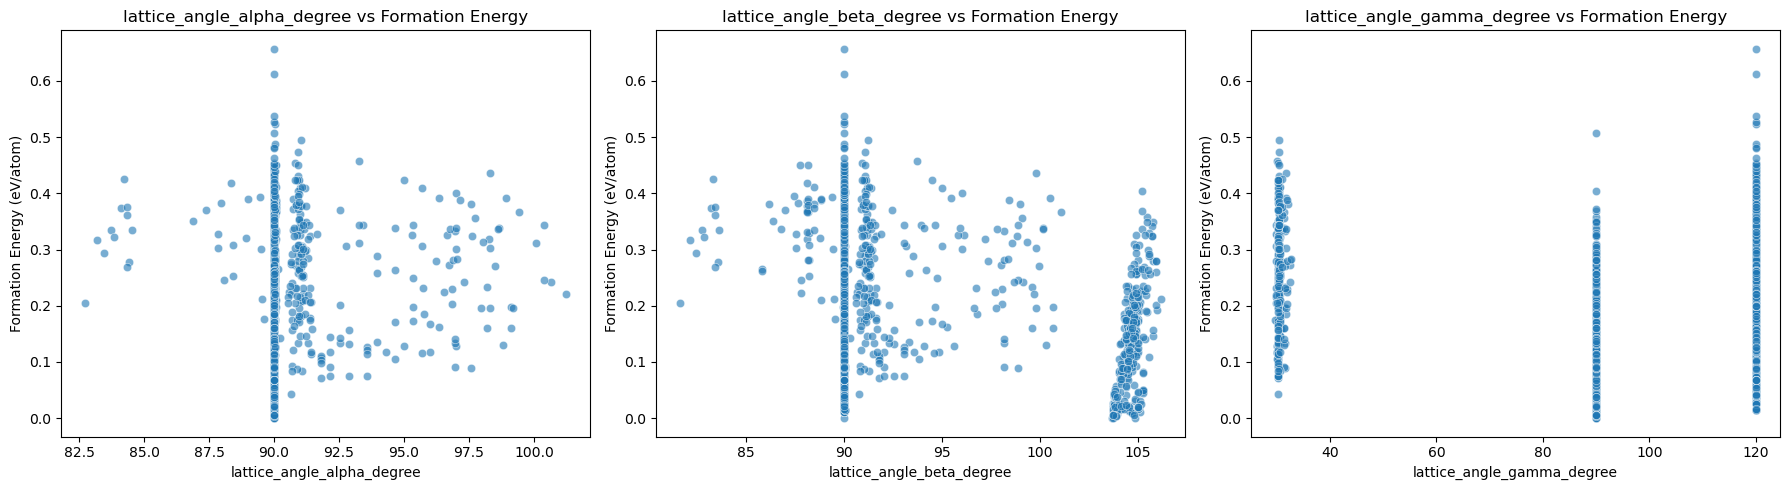

In [309]:
plt.figure(figsize=(18,5))

for i, col in enumerate(angle_cols):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=train_df, x=col, y='formation_energy_ev_natom', alpha=0.6)
    plt.title(f"{col} vs Formation Energy")
    plt.xlabel(col)
    plt.ylabel("Formation Energy (eV/atom)")

plt.tight_layout()
plt.show()


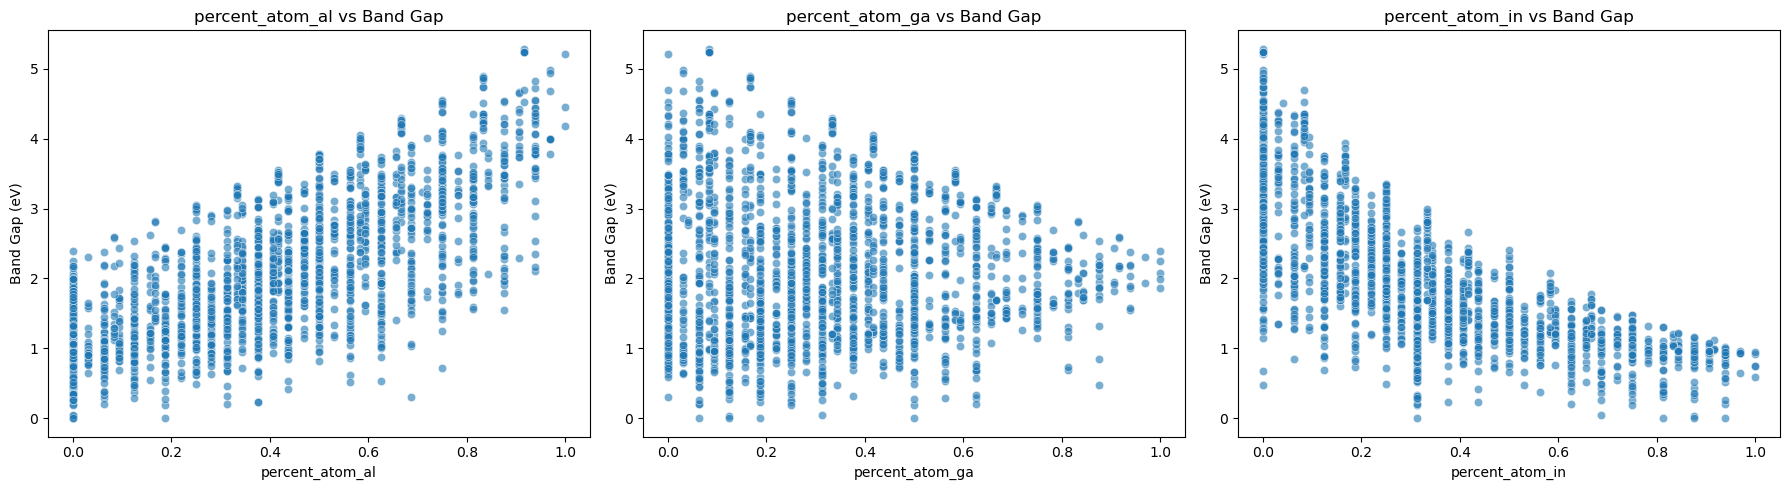

In [310]:
pct_cols = ['percent_atom_al', 'percent_atom_ga', 'percent_atom_in']

plt.figure(figsize=(18,5))
for i, col in enumerate(pct_cols):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=train_df, x=col, y='bandgap_energy_ev', alpha=0.6)
    plt.title(f"{col} vs Band Gap")
    plt.xlabel(col)
    plt.ylabel("Band Gap (eV)")

plt.tight_layout()
plt.show()


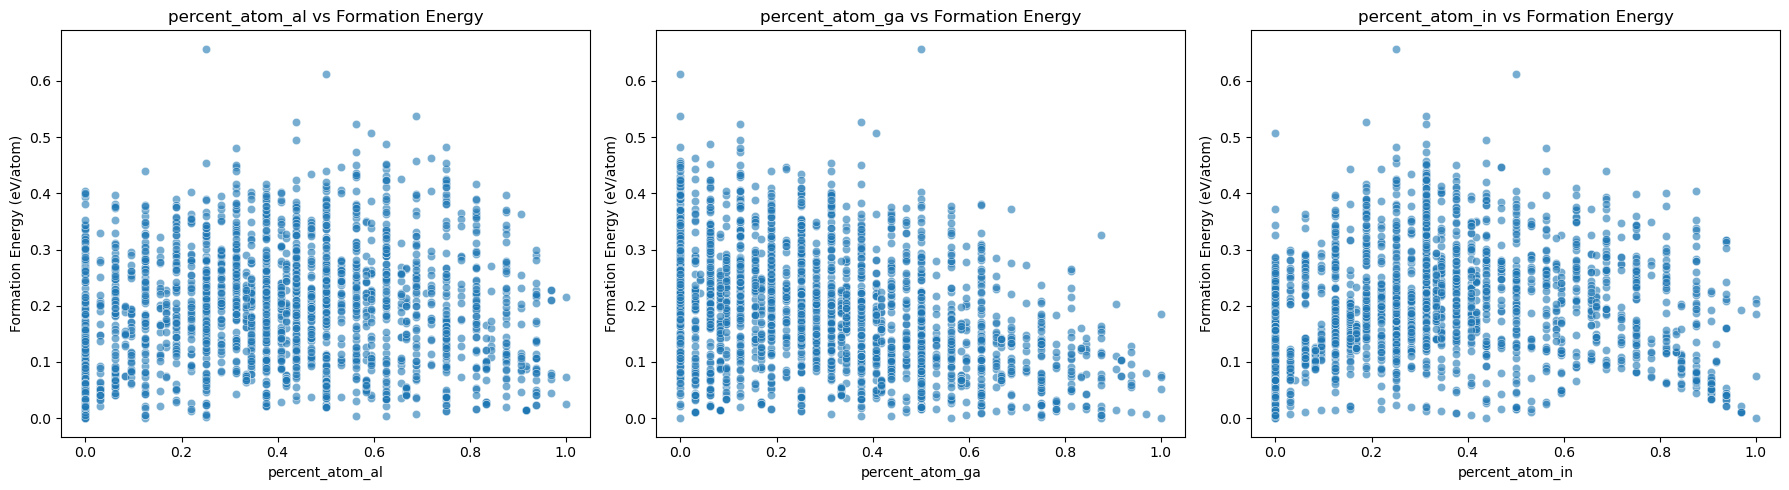

In [311]:
plt.figure(figsize=(18,5))
for i, col in enumerate(pct_cols):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=train_df, x=col, y='formation_energy_ev_natom', alpha=0.6)
    plt.title(f"{col} vs Formation Energy")
    plt.xlabel(col)
    plt.ylabel("Formation Energy (eV/atom)")

plt.tight_layout()
plt.show()


In [312]:
hue='stability'
size='number_of_total_atoms'


In [313]:
def dom_element(row):
    vals = {
        'Al-rich': row['percent_atom_al'],
        'Ga-rich': row['percent_atom_ga'],
        'In-rich': row['percent_atom_in']
    }
    return max(vals, key=vals.get)

train_df['dominant_element'] = train_df.apply(dom_element, axis=1)


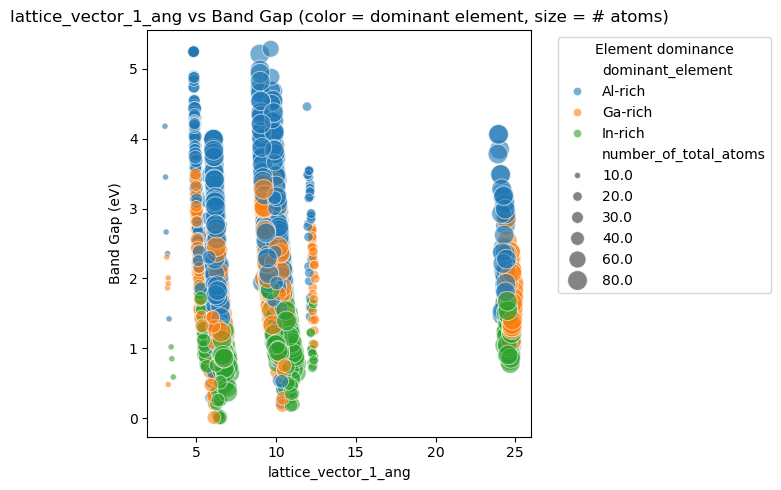

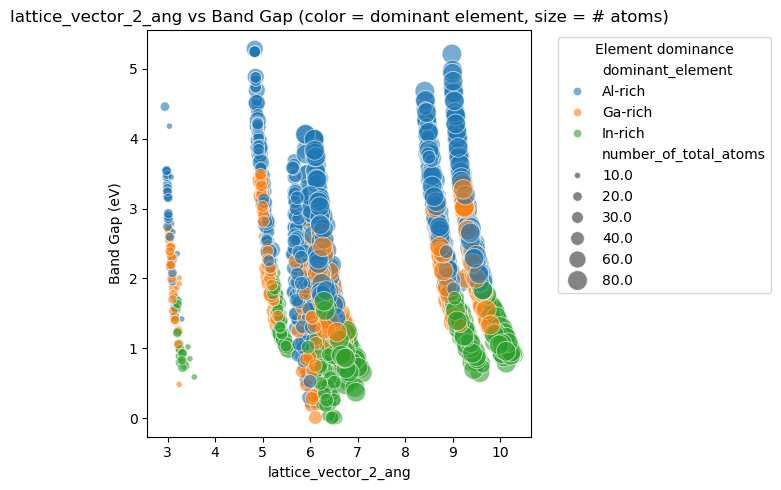

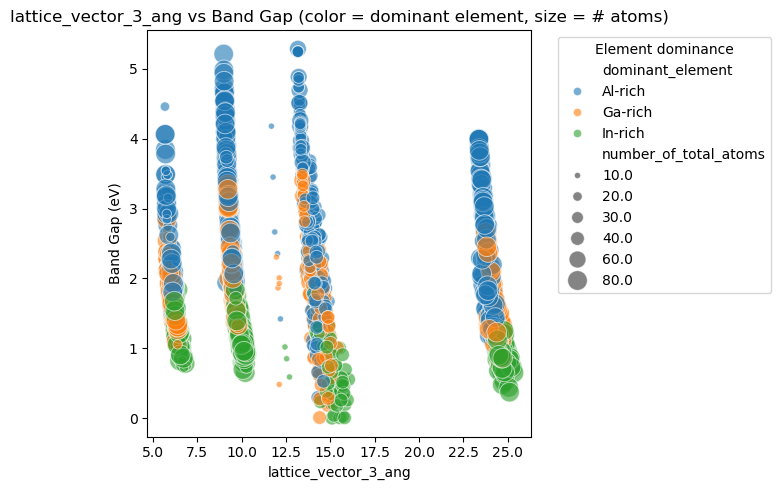

In [314]:
vec_cols = ['lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang']

for col in vec_cols:
    plt.figure(figsize=(7,5))
    sns.scatterplot(
        data=train_df,
        x=col,
        y='bandgap_energy_ev',
        hue='dominant_element',           # <- NEW
        size='number_of_total_atoms',
        sizes=(20, 200),
        alpha=0.6
    )
    plt.title(f"{col} vs Band Gap (color = dominant element, size = # atoms)")
    plt.xlabel(col)
    plt.ylabel("Band Gap (eV)")
    plt.legend(title="Element dominance", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


Coloring by the dominant chemical species (Al-rich, Ga-rich, In-rich) reveals strong composition–structure–property patterns.
Al-rich materials tend to exhibit higher band gaps and cluster around smaller lattice vector magnitudes, consistent with tighter bonding.
In-rich materials appear primarily in the low band gap region and cluster at larger lattice vectors due to the larger ionic radius of In.
Ga-rich materials form an intermediate transition group between the two extremes.
The marker size (representing number of atoms) shows that structural complexity does not dominate band gap behavior compared to composition and lattice geometry.

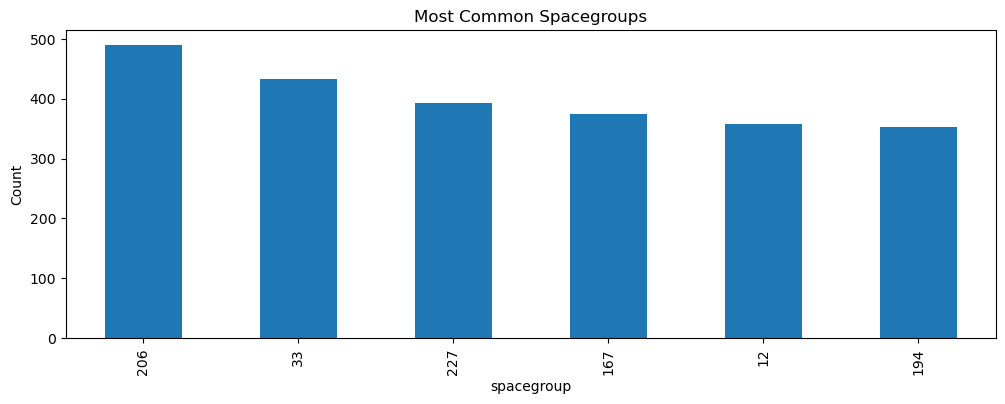

In [315]:
plt.figure(figsize=(12,4))
train_df['spacegroup'].value_counts().head(20).plot(kind='bar')
plt.title("Most Common Spacegroups")
plt.ylabel("Count")
plt.show()


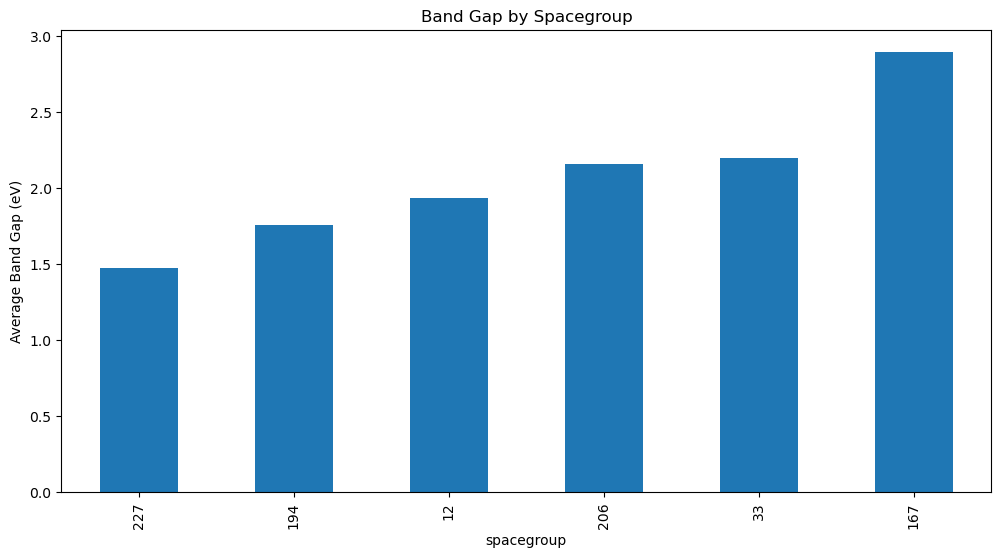

In [316]:
sg_gap = train_df.groupby('spacegroup')['bandgap_energy_ev'].mean().sort_values()

plt.figure(figsize=(12,6))
sg_gap.plot(kind='bar')
plt.ylabel("Average Band Gap (eV)")
plt.title("Band Gap by Spacegroup")
plt.show()


Spacegroups strongly influence electronic behavior because symmetry constraints affect band dispersion and orbital overlap. Certain spacegroups consistently exhibit higher average band gaps (likely more ionic, highly symmetric structures), while others have lower gaps (often more covalent or metallic).
This confirms that symmetry is a valuable structural descriptor and should be included in downstream models either directly (encoded spacegroup) or through embeddings.

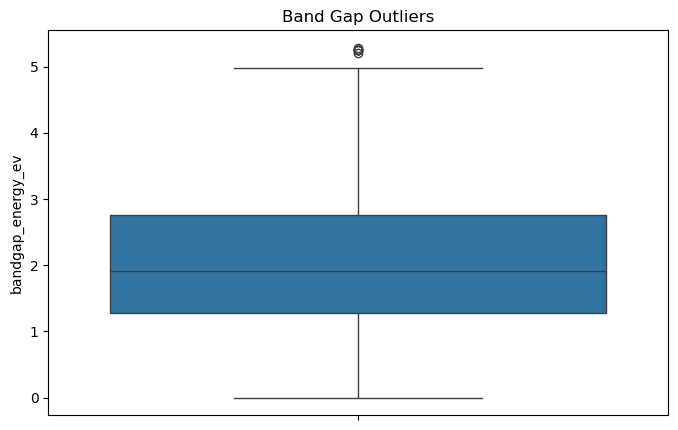

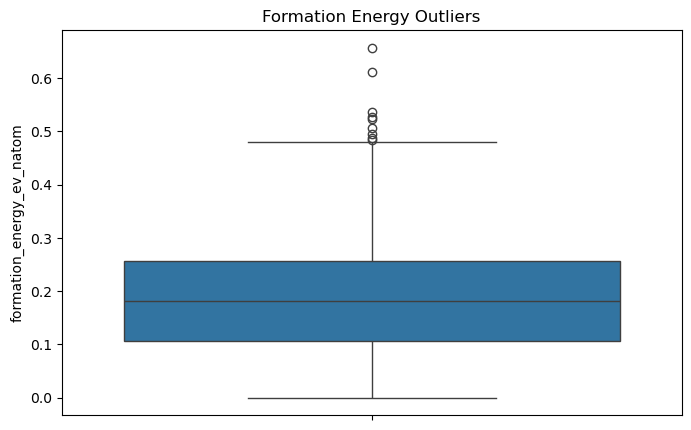

In [317]:
plt.figure(figsize=(8,5))
sns.boxplot(data=train_df['bandgap_energy_ev'])
plt.title("Band Gap Outliers")
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(data=train_df['formation_energy_ev_natom'])
plt.title("Formation Energy Outliers")
plt.show()


In [318]:
train_df['approx_volume'] = (
    train_df['lattice_vector_1_ang'] *
    train_df['lattice_vector_2_ang'] *
    train_df['lattice_vector_3_ang']
)


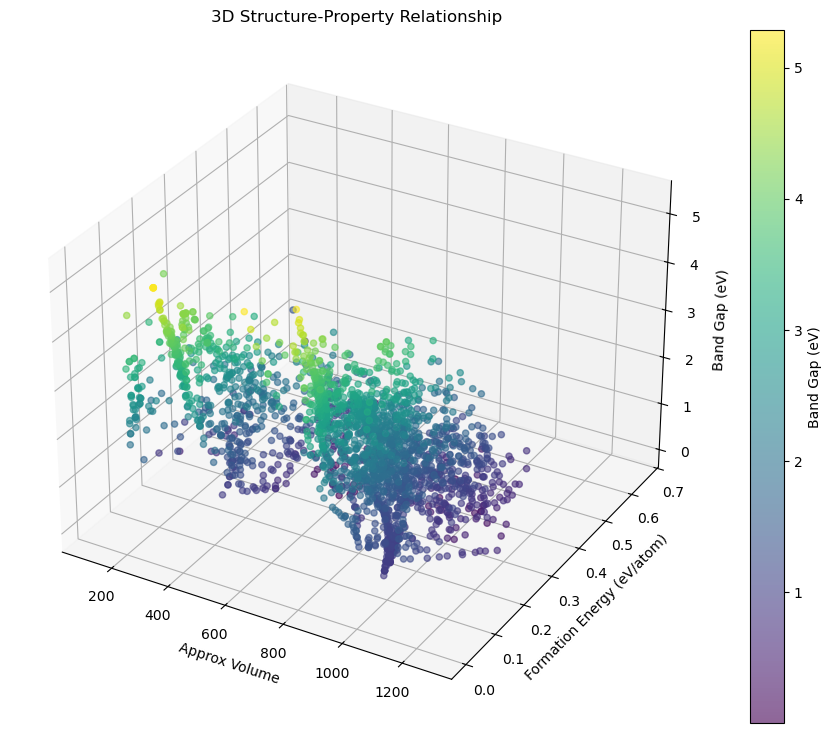

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(12,9))
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(
#     train_df['approx_volume'],
#     train_df['formation_energy_ev_natom'],
#     train_df['bandgap_energy_ev'],
#     alpha=0.4
# )


fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(
    train_df['approx_volume'],
    train_df['formation_energy_ev_natom'],
    train_df['bandgap_energy_ev'],
    c=train_df['bandgap_energy_ev'],
    cmap='viridis',
    alpha=0.6
)
fig.colorbar(p, ax=ax, label="Band Gap (eV)")

ax.set_xlabel('Approx Volume')
ax.set_ylabel('Formation Energy (eV/atom)')
ax.set_zlabel('Band Gap (eV)')
plt.title("3D Structure-Property Relationship")
plt.show()



In [363]:
vec_cols = ['lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang']
ang_cols = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']

feature_cols = vec_cols + ang_cols + [
    'number_of_total_atoms',
    'percent_atom_al', 'percent_atom_ga', 'percent_atom_in'
]

In [361]:
train_df['volume_density'] = train_df['number_of_total_atoms'] / train_df['approx_volume']
train_df['avg_lattice_length'] = train_df[vec_cols].mean(axis=1)
train_df['angle_variance'] = train_df[ang_cols].var(axis=1)


In [364]:
train_df['max_lattice_vector'] = train_df[vec_cols].max(axis=1)
train_df['min_lattice_vector'] = train_df[vec_cols].min(axis=1)
train_df['ratio_lattice_1_3'] = train_df['lattice_vector_1_ang'] / train_df['lattice_vector_3_ang']

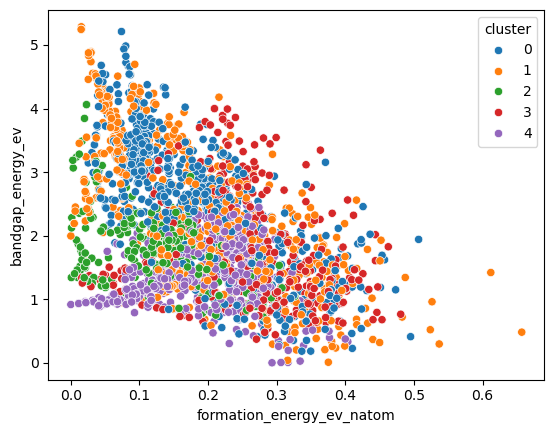

In [365]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = train_df[
    vec_cols +
    ang_cols +
    ['number_of_total_atoms', 'percent_atom_al', 'percent_atom_ga', 'percent_atom_in']
]

X = StandardScaler().fit_transform(features)

kmeans = KMeans(n_clusters=5, random_state=0)
train_df['cluster'] = kmeans.fit_predict(X)

sns.scatterplot(
    data=train_df,
    x='formation_energy_ev_natom',
    y='bandgap_energy_ev',
    hue='cluster',
    palette='tab10'
)

plt.show()


Structural Clusters in PCA Space (without target leak)

In [366]:
vec_cols = ['lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang']
ang_cols = ['lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree']

feature_cols = vec_cols + ang_cols + [
    'number_of_total_atoms',
    'percent_atom_al', 'percent_atom_ga', 'percent_atom_in'
]


In [367]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = train_df[feature_cols]
X_scaled = StandardScaler().fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
train_df['cluster'] = kmeans.fit_predict(X_scaled)


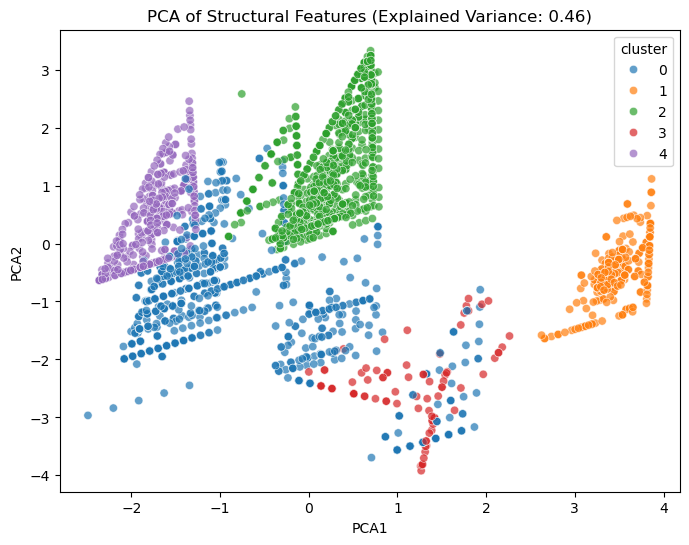

In [368]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

train_df['PCA1'] = X_pca[:, 0]
train_df['PCA2'] = X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=train_df,
    x='PCA1', y='PCA2',
    hue='cluster',
    palette='tab10',
    alpha=0.7
)
plt.title(f"PCA of Structural Features (Explained Variance: {pca.explained_variance_ratio_.sum():.2f})")
plt.show()


Clusters 2 and 0 (majority of dataset)
→ represent the two dominant structure types in NOMAD 2018 conductors dataset
→ likely common oxide / semiconductor crystal families

Cluster 4 (~1/6 of dataset)
→ clearly separated on PCA1
→ likely a distinct lattice system (e.g., orthorhombic)

Cluster 1 (~small part of dataset)
→ another structurally distinct but smaller lattice family

Cluster 3 (~smallest part of dataset)
→ rare structure class
→ may correspond to unusual or metastable structures

In [326]:
train_df['cluster'].value_counts()


cluster
2    877
0    824
4    340
1    274
3     85
Name: count, dtype: int64

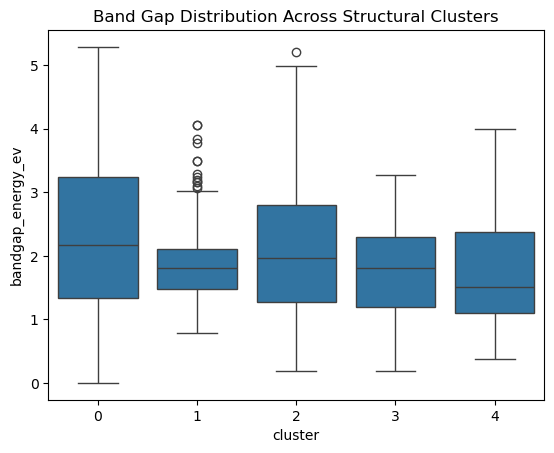

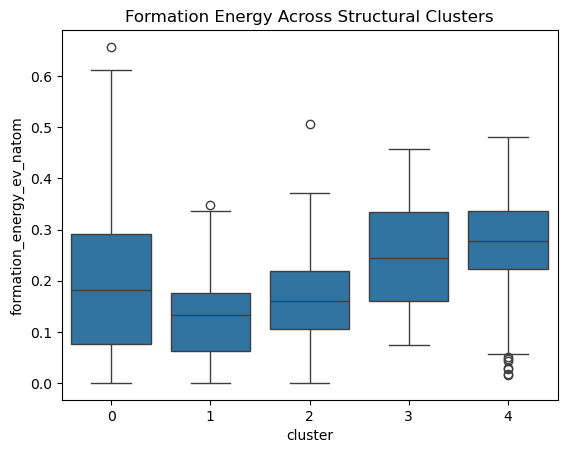

In [327]:
sns.boxplot(data=train_df, x='cluster', y='bandgap_energy_ev')
plt.title("Band Gap Distribution Across Structural Clusters")
plt.show()

sns.boxplot(data=train_df, x='cluster', y='formation_energy_ev_natom')
plt.title("Formation Energy Across Structural Clusters")
plt.show()


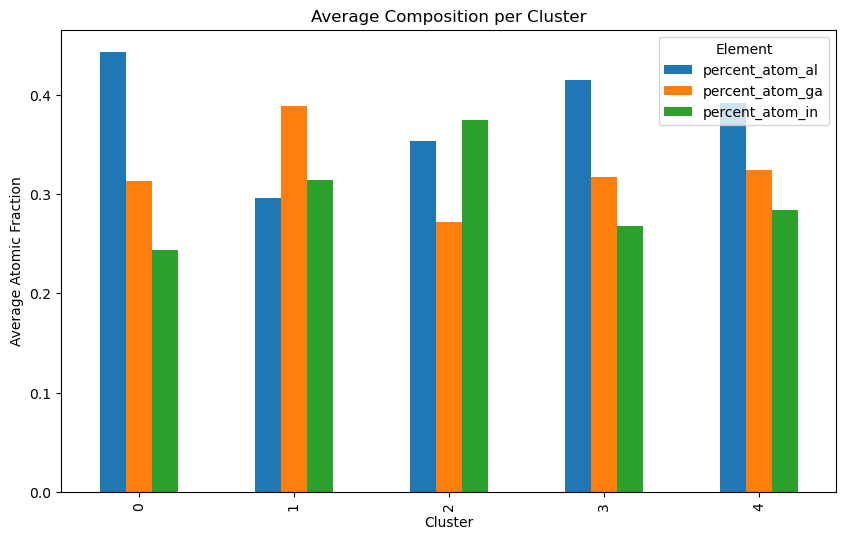

In [328]:
comp_cols = ['percent_atom_al', 'percent_atom_ga', 'percent_atom_in']

cluster_comp = (
    train_df.groupby('cluster')[comp_cols]
    .mean()
    .sort_index()
)

cluster_comp.plot(kind='bar', figsize=(10,6))
plt.title("Average Composition per Cluster")
plt.ylabel("Average Atomic Fraction")
plt.xlabel("Cluster")
plt.legend(title="Element")
plt.show()


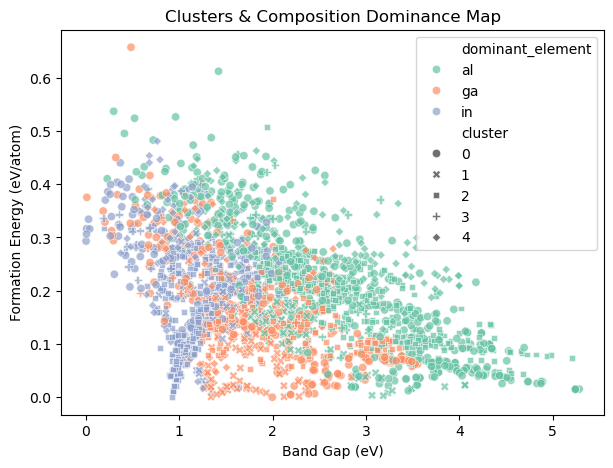

In [329]:
def dominant_elem(row):
    vals = row[comp_cols]
    return vals.idxmax().replace("percent_atom_", "")

train_df["dominant_element"] = train_df.apply(dominant_elem, axis=1)

plt.figure(figsize=(7,5))
sns.scatterplot(
    data=train_df,
    x="bandgap_energy_ev",
    y="formation_energy_ev_natom",
    hue="dominant_element",
    style="cluster",
    alpha=0.7,
    palette="Set2"
)
plt.title("Clusters & Composition Dominance Map")
plt.xlabel("Band Gap (eV)")
plt.ylabel("Formation Energy (eV/atom)")
plt.show()


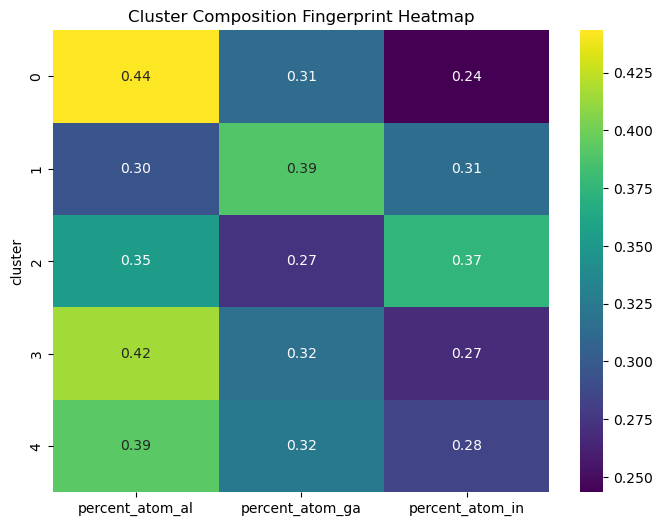

In [330]:
plt.figure(figsize=(8,6))
sns.heatmap(cluster_comp, annot=True, cmap="viridis", fmt=".2f")
plt.title("Cluster Composition Fingerprint Heatmap")
plt.show()


SHAP for Prep ML Model

In [ ]:
# FOR BAND GAP ENERGY -- BELOW IS FORMATION ENERGY
feature_cols = [
    'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang',
    'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree',
    'percent_atom_al', 'percent_atom_ga', 'percent_atom_in',
    'number_of_total_atoms', 'approx_volume', 'volume_density',
    'avg_lattice_length', 'angle_variance'
]

X = train_df[feature_cols]
y = train_df['bandgap_energy_ev']   # try formation energy next
# y = train_df['formation_energy_ev_natom'] 


In [339]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=42)

In [340]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


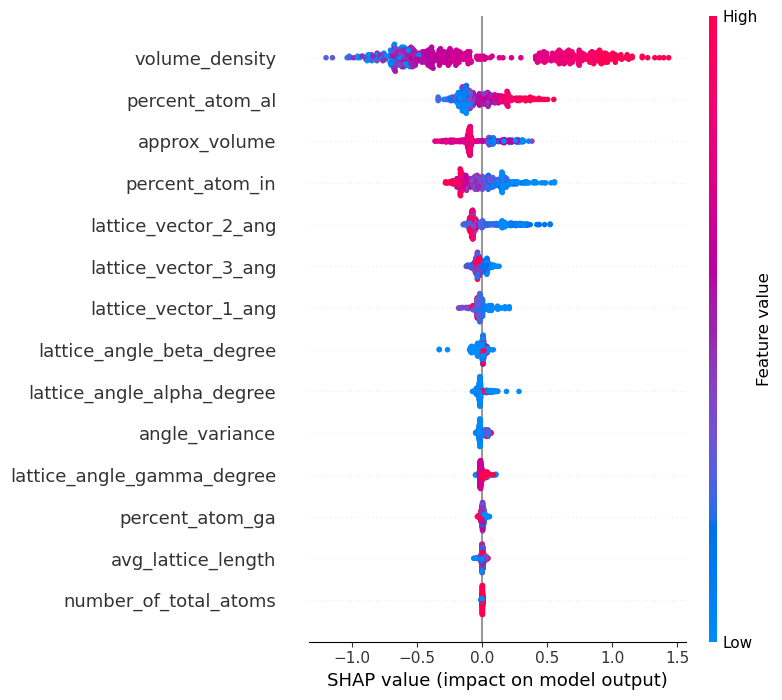

In [341]:
shap.summary_plot(shap_values, X_test, plot_type="dot")


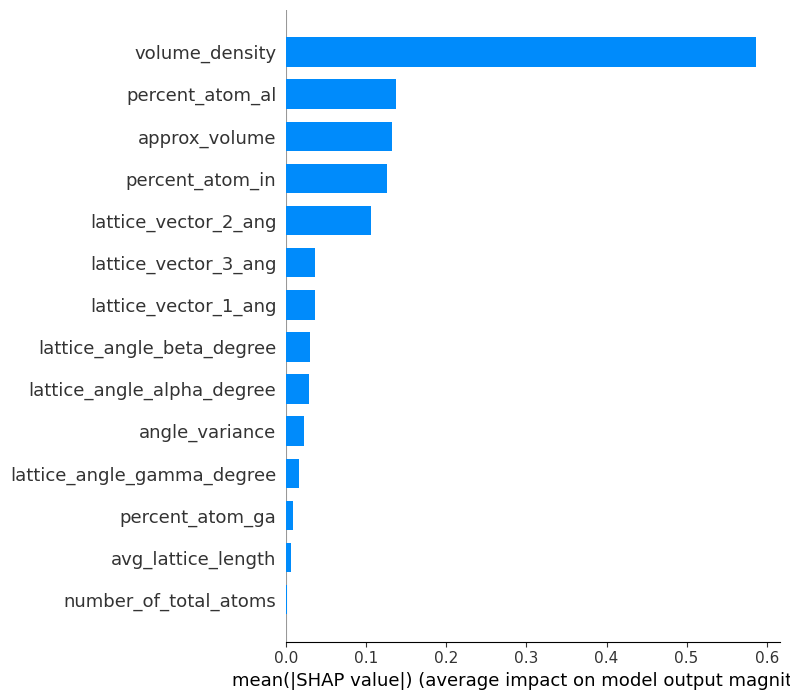

In [342]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


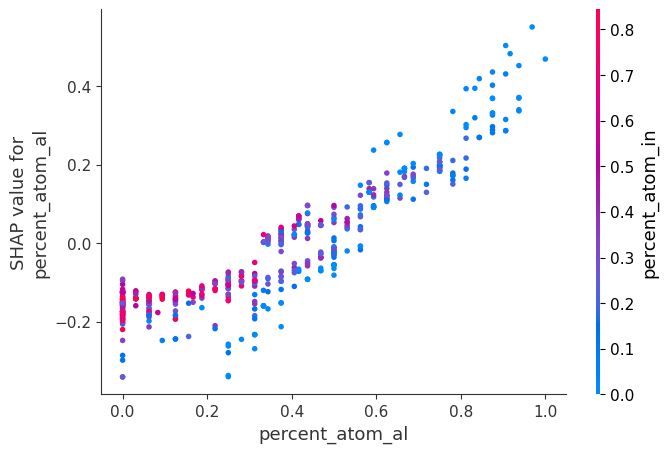

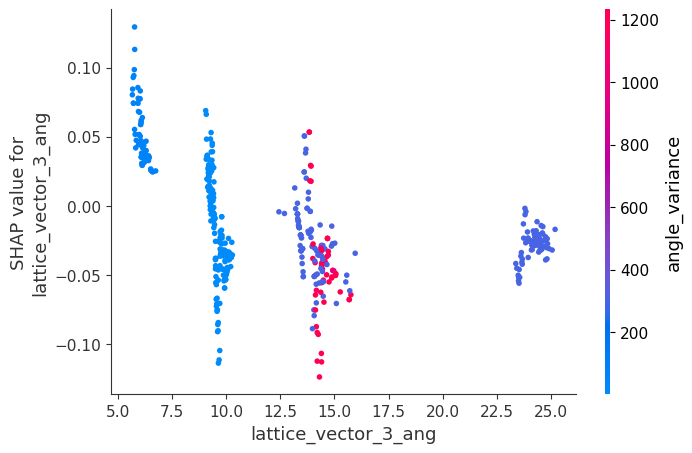

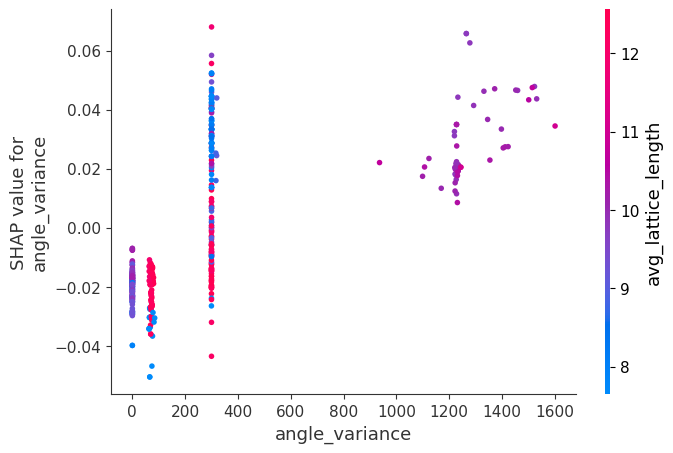

In [343]:
shap.dependence_plot("percent_atom_al", shap_values, X_test)
shap.dependence_plot("lattice_vector_3_ang", shap_values, X_test)
shap.dependence_plot("angle_variance", shap_values, X_test)


In [344]:
# FOR FORMATION ENERGY
feature_cols = [
    'lattice_vector_1_ang', 'lattice_vector_2_ang', 'lattice_vector_3_ang',
    'lattice_angle_alpha_degree', 'lattice_angle_beta_degree', 'lattice_angle_gamma_degree',
    'percent_atom_al', 'percent_atom_ga', 'percent_atom_in',
    'number_of_total_atoms', 'approx_volume', 'volume_density',
    'avg_lattice_length', 'angle_variance'
]

X = train_df[feature_cols]
# y = train_df['bandgap_energy_ev']   # try formation energy next
y = train_df['formation_energy_ev_natom'] 

In [345]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=400, n_jobs=-1, random_state=42)

In [346]:
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


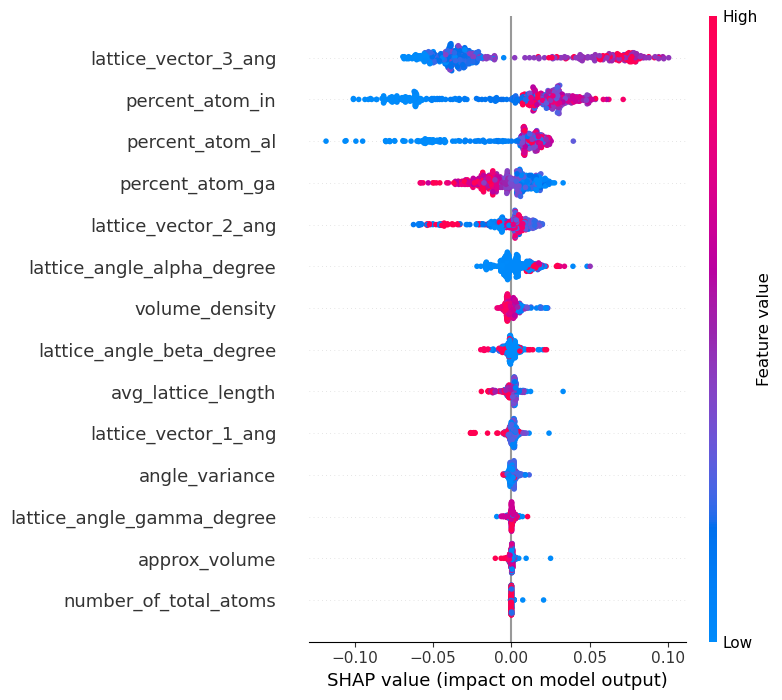

In [347]:
shap.summary_plot(shap_values, X_test, plot_type="dot")

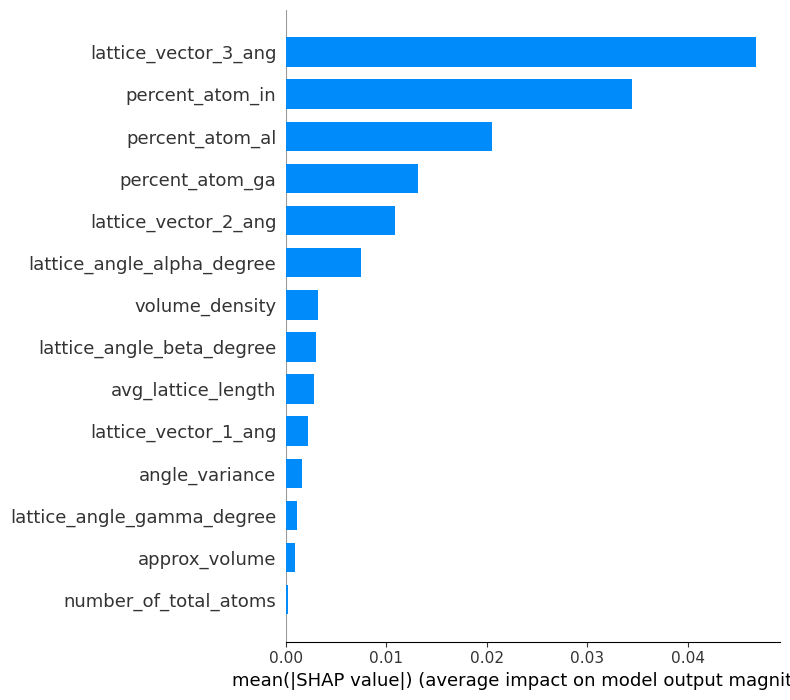

In [348]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

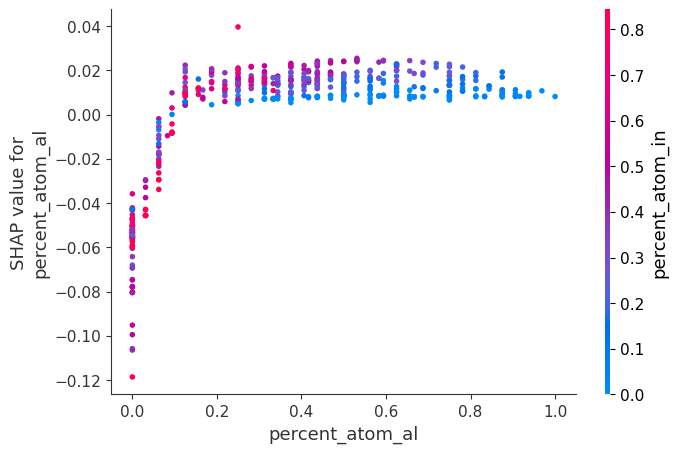

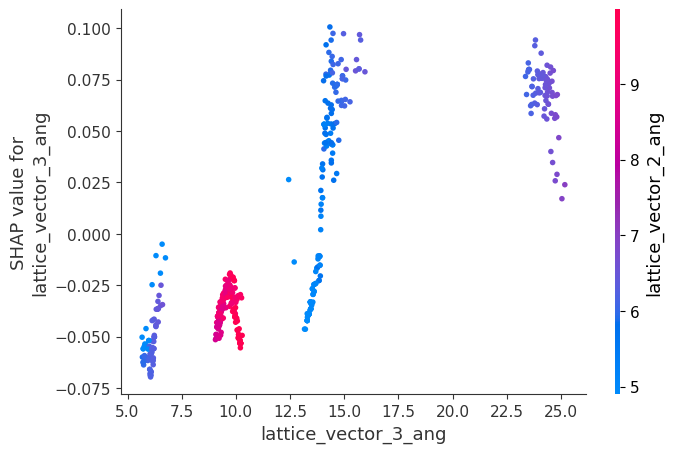

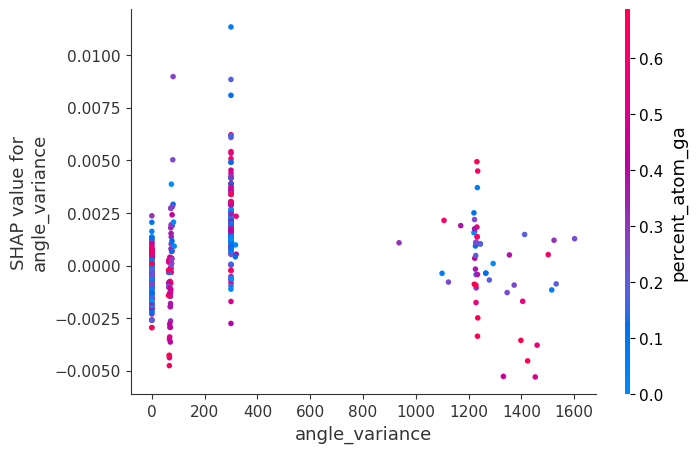

In [349]:
shap.dependence_plot("percent_atom_al", shap_values, X_test)
shap.dependence_plot("lattice_vector_3_ang", shap_values, X_test)
shap.dependence_plot("angle_variance", shap_values, X_test)

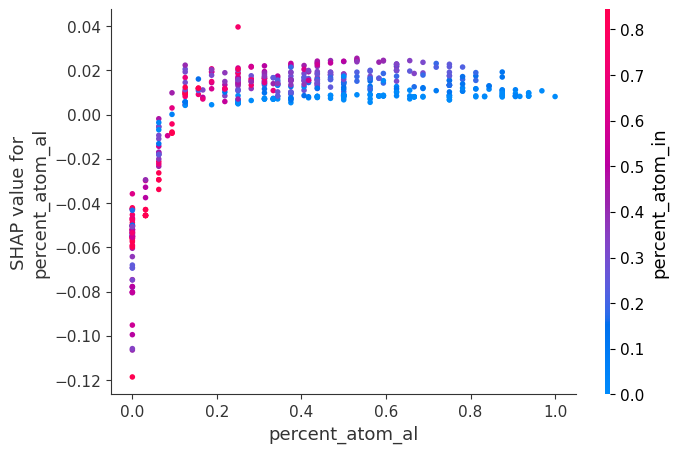

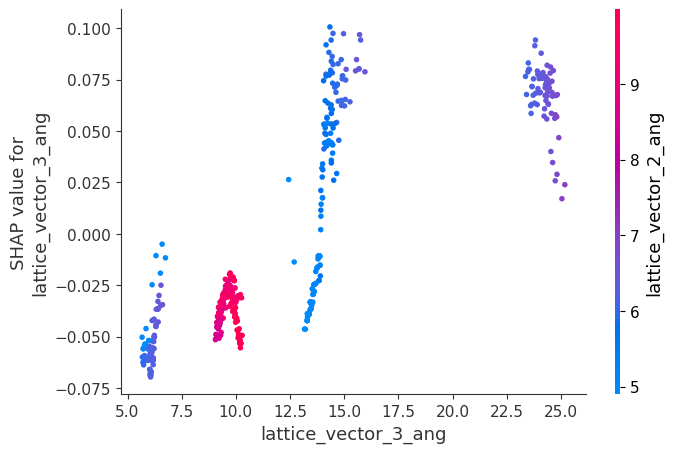

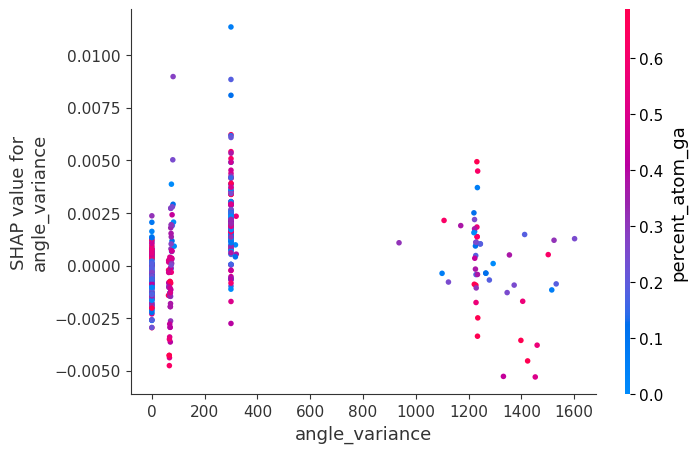

In [350]:
shap.dependence_plot("percent_atom_al", shap_values, X_test)
shap.dependence_plot("lattice_vector_3_ang", shap_values, X_test)
shap.dependence_plot("angle_variance", shap_values, X_test)

BREAK BREAK BREAK

In [ ]:
import numpy as np
import pandas as pd

feature_cols = [
    "number_of_total_atoms",
    "percent_atom_al", "percent_atom_ga", "percent_atom_in",
    "lattice_vector_1_ang", "lattice_vector_2_ang", "lattice_vector_3_ang",
    "lattice_angle_alpha_degree", "lattice_angle_beta_degree", "lattice_angle_gamma_degree",
    "approx_volume", "volume_density", "avg_lattice_length", "angle_variance",
]

target_col = "bandgap_energy_ev"          # main target for now
# target_col = "formation_energy_ev_natom"   # <- swap later


In [370]:
data = train_df[feature_cols + [target_col]].dropna().copy()

X = data[feature_cols].values
y = data[target_col].values


In [377]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [379]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_val)

mae_dummy = mean_absolute_error(y_val, y_pred_dummy)
rmse_dummy = root_mean_squared_error(y_val, y_pred_dummy)

print("Dummy baseline (predict mean):")
print(f"  MAE  = {mae_dummy:.3f}")
print(f"  RMSE = {rmse_dummy:.3f}")


Dummy baseline (predict mean):
  MAE  = 0.828
  RMSE = 0.992


In [381]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

lin_model = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_val)

mae_lin = mean_absolute_error(y_val, y_pred_lin)
rmse_lin = root_mean_squared_error(y_val, y_pred_lin)

print("\nLinear Regression baseline:")
print(f"  MAE  = {mae_lin:.3f}")
print(f"  RMSE = {rmse_lin:.3f}")



Linear Regression baseline:
  MAE  = 0.226
  RMSE = 0.324


In [382]:
from sklearn.model_selection import cross_val_score

cv_rmse = -cross_val_score(
    lin_model, X, y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

print(f"\n5-fold CV RMSE (Linear): mean={cv_rmse.mean():.3f}, std={cv_rmse.std():.3f}")



5-fold CV RMSE (Linear): mean=0.326, std=0.011


CHANGE to ...formation energy

In [383]:
import numpy as np
import pandas as pd

feature_cols = [
    "number_of_total_atoms",
    "percent_atom_al", "percent_atom_ga", "percent_atom_in",
    "lattice_vector_1_ang", "lattice_vector_2_ang", "lattice_vector_3_ang",
    "lattice_angle_alpha_degree", "lattice_angle_beta_degree", "lattice_angle_gamma_degree",
    "approx_volume", "volume_density", "avg_lattice_length", "angle_variance",
]

# target_col = "bandgap_energy_ev"          # main target for now
target_col = "formation_energy_ev_natom"   # <- swap later


In [384]:
data = train_df[feature_cols + [target_col]].dropna().copy()

X = data[feature_cols].values
y = data[target_col].values


In [385]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [386]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_val)

mae_dummy = mean_absolute_error(y_val, y_pred_dummy)
rmse_dummy = root_mean_squared_error(y_val, y_pred_dummy)

print("Dummy baseline (predict mean):")
print(f"  MAE  = {mae_dummy:.3f}")
print(f"  RMSE = {rmse_dummy:.3f}")

Dummy baseline (predict mean):
  MAE  = 0.084
  RMSE = 0.103


In [387]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

lin_model = Pipeline([
    ("scaler", StandardScaler()),
    ("reg", LinearRegression())
])

lin_model.fit(X_train, y_train)
y_pred_lin = lin_model.predict(X_val)

mae_lin = mean_absolute_error(y_val, y_pred_lin)
rmse_lin = root_mean_squared_error(y_val, y_pred_lin)

print("\nLinear Regression baseline:")
print(f"  MAE  = {mae_lin:.3f}")
print(f"  RMSE = {rmse_lin:.3f}")


Linear Regression baseline:
  MAE  = 0.056
  RMSE = 0.075


In [388]:
from sklearn.model_selection import cross_val_score

cv_rmse = -cross_val_score(
    lin_model, X, y,
    cv=5,
    scoring="neg_root_mean_squared_error"
)

print(f"\n5-fold CV RMSE (Linear): mean={cv_rmse.mean():.3f}, std={cv_rmse.std():.3f}")


5-fold CV RMSE (Linear): mean=0.073, std=0.001


| Target               | Dummy RMSE | Linear RMSE | CV Std | Predictability | Notes                                                        |
| -------------------- | ---------- | ----------- | ------ | -------------- | ------------------------------------------------------------ |
| **Band Gap**         | ~0.99      | ~0.32       | 0.011  | Moderate       | Strong nonlinear effects, composition very important         |
| **Formation Energy** | ~0.10      | ~0.075      | 0.001  | Easy           | Very smooth physical mapping; features capture most variance |


BREAK BREAK BREAK

In [394]:
from sklearn.model_selection import train_test_split

full_train = train_df.copy()  # original full train
train_df, val_df = train_test_split(
    full_train,
    test_size=0.2,
    random_state=42,
)

In [395]:
feature_cols = [
    # whatever you decided to use
    "number_of_total_atoms",
    "percent_atom_al",
    "percent_atom_ga",
    "percent_atom_in",
    "lattice_vector_1_ang",
    "lattice_vector_2_ang",
    "lattice_vector_3_ang",
    "lattice_angle_alpha_degree",
    "lattice_angle_beta_degree",
    "lattice_angle_gamma_degree",
    "approx_volume",
    "volume_density",
    "avg_lattice_length",
    "angle_variance",
]

# X already split
X_train = train_df[feature_cols].copy()
X_val   = val_df[feature_cols].copy()


In [402]:
target_cols = {
    "bandgap": "bandgap_energy_ev",
    "formation_energy": "formation_energy_ev_natom",
}

In [401]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def evaluate_model(model, target_name, target_col):
    """
    Fit `model` on X_train and the given target column,
    evaluate on X_val, and print MAE/RMSE.
    """
    y_train = train_df[target_col]
    y_val   = val_df[target_col]

    model.fit(X_train, y_train)
    preds = model.predict(X_val)

    mae  = mean_absolute_error(y_val, preds)
    rmse = root_mean_squared_error(y_val, preds)

    print(f"\n=== {target_name} ({target_col}) — {model.__class__.__name__} ===")
    print(f"MAE  = {mae:.3f}")
    print(f"RMSE = {rmse:.3f}")

    return mae, rmse


In [403]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

for name, col in target_cols.items():
    evaluate_model(linreg, name, col)



=== bandgap (bandgap_energy_ev) — LinearRegression ===
MAE  = 0.226
RMSE = 0.324

=== formation_energy (formation_energy_ev_natom) — LinearRegression ===
MAE  = 0.056
RMSE = 0.075


In [404]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

models = [
    DummyRegressor(strategy="mean"),
    LinearRegression(),
    Ridge(alpha=1.0),
    Lasso(alpha=0.001, max_iter=10000),
]

for target_name, target_col in target_cols.items():
    for model in models:
        evaluate_model(model, target_name, target_col)



=== bandgap (bandgap_energy_ev) — DummyRegressor ===
MAE  = 0.828
RMSE = 0.992

=== bandgap (bandgap_energy_ev) — LinearRegression ===
MAE  = 0.226
RMSE = 0.324

=== bandgap (bandgap_energy_ev) — Ridge ===
MAE  = 0.306
RMSE = 0.425

=== bandgap (bandgap_energy_ev) — Lasso ===
MAE  = 0.307
RMSE = 0.427

=== formation_energy (formation_energy_ev_natom) — DummyRegressor ===
MAE  = 0.084
RMSE = 0.103

=== formation_energy (formation_energy_ev_natom) — LinearRegression ===
MAE  = 0.056
RMSE = 0.075

=== formation_energy (formation_energy_ev_natom) — Ridge ===
MAE  = 0.063
RMSE = 0.082

=== formation_energy (formation_energy_ev_natom) — Lasso ===
MAE  = 0.064
RMSE = 0.083


In [405]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

def evaluate_model(model, X_train, y_train, X_val, y_val, name="Model for BG"):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    mae = mean_absolute_error(y_val, preds)
    rmse = root_mean_squared_error(y_val, preds)
    print(f"{name}: MAE={mae:.4f}, RMSE={rmse:.4f}")
    return mae, rmse

ridge = Ridge(alpha=1.0)
evaluate_model(ridge, X_train, y_train, X_val, y_val, name="Ridge")


Ridge: MAE=0.0626, RMSE=0.0820


(0.0626472339467048, 0.08197249512437922)

In [407]:
import numpy as np

alphas = np.logspace(-3, 3, 20)
best = None
for a in alphas:
    model = Ridge(alpha=a)
    mae, rmse = evaluate_model(model, X_train, y_train, X_val, y_val,
                               name=f"Ridge (alpha={a})")


Ridge (alpha=0.001): MAE=0.0565, RMSE=0.0750
Ridge (alpha=0.00206913808111479): MAE=0.0568, RMSE=0.0752
Ridge (alpha=0.004281332398719396): MAE=0.0574, RMSE=0.0757
Ridge (alpha=0.008858667904100823): MAE=0.0585, RMSE=0.0767
Ridge (alpha=0.018329807108324356): MAE=0.0598, RMSE=0.0782
Ridge (alpha=0.0379269019073225): MAE=0.0609, RMSE=0.0797
Ridge (alpha=0.07847599703514611): MAE=0.0617, RMSE=0.0808
Ridge (alpha=0.1623776739188721): MAE=0.0622, RMSE=0.0814
Ridge (alpha=0.3359818286283781): MAE=0.0625, RMSE=0.0817
Ridge (alpha=0.6951927961775606): MAE=0.0626, RMSE=0.0819
Ridge (alpha=1.438449888287663): MAE=0.0627, RMSE=0.0820
Ridge (alpha=2.976351441631316): MAE=0.0628, RMSE=0.0821
Ridge (alpha=6.158482110660261): MAE=0.0629, RMSE=0.0821
Ridge (alpha=12.742749857031322): MAE=0.0632, RMSE=0.0822
Ridge (alpha=26.366508987303554): MAE=0.0636, RMSE=0.0824
Ridge (alpha=54.555947811685144): MAE=0.0644, RMSE=0.0828
Ridge (alpha=112.88378916846884): MAE=0.0656, RMSE=0.0836
Ridge (alpha=233.57214

In [408]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, max_iter=10000)
evaluate_model(lasso, X_train, y_train, X_val, y_val, name="Lasso")


Lasso: MAE=0.0640, RMSE=0.0830


(0.06400766422355332, 0.08302230982071811)

In [409]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1
)

evaluate_model(rf, X_train, y_train, X_val, y_val, name="Random Forest")


Random Forest: MAE=0.0287, RMSE=0.0479


(0.028656801452524493, 0.04785344099202284)

In [412]:
importances = rf.feature_importances_
for name, imp in sorted(zip(X_train.columns, importances), key=lambda x: -x[1]):
    print(f"{name}: {imp:.4f}")


lattice_vector_3_ang: 0.3711
percent_atom_in: 0.2031
percent_atom_al: 0.1198
lattice_vector_2_ang: 0.0732
percent_atom_ga: 0.0674
lattice_angle_alpha_degree: 0.0313
lattice_angle_beta_degree: 0.0270
volume_density: 0.0245
lattice_vector_1_ang: 0.0211
avg_lattice_length: 0.0208
angle_variance: 0.0147
lattice_angle_gamma_degree: 0.0123
approx_volume: 0.0112
number_of_total_atoms: 0.0025


In [413]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

evaluate_model(xgb, X_train, y_train, X_val, y_val, name="XGBoost")


XGBoost: MAE=0.0286, RMSE=0.0479


(0.028591506585565706, 0.047912031669269)

In [416]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [419]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

multi_rf = MultiOutputRegressor(
    RandomForestRegressor(n_estimators=300, random_state=42)
)

y_train_multi = train_df[['bandgap_energy_ev', 'formation_energy_ev_natom']]
y_val_multi = val_df[['bandgap_energy_ev', 'formation_energy_ev_natom']]

multi_rf.fit(X_train, y_train_multi)
preds_multi = multi_rf.predict(X_val)

from sklearn.metrics import root_mean_squared_error

rmse_bg  = root_mean_squared_error(y_val_multi.iloc[:,0], preds_multi[:,0])
rmse_fe  = root_mean_squared_error(y_val_multi.iloc[:,1], preds_multi[:,1])

print("Multi-target RF:")
print("RMSE Bandgap:", rmse_bg)
print("RMSE FormEnergy:", rmse_fe)


Multi-target RF:
RMSE Bandgap: 0.24680653414272882
RMSE FormEnergy: 0.04785344099202285
